
# 第9章：速度提升II：精度(Precision) - Notebook辅助教程

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import numpy as np
import time
import random

1. 浮点精度可视化

首先，让我们可视化不同浮点格式的位分配：

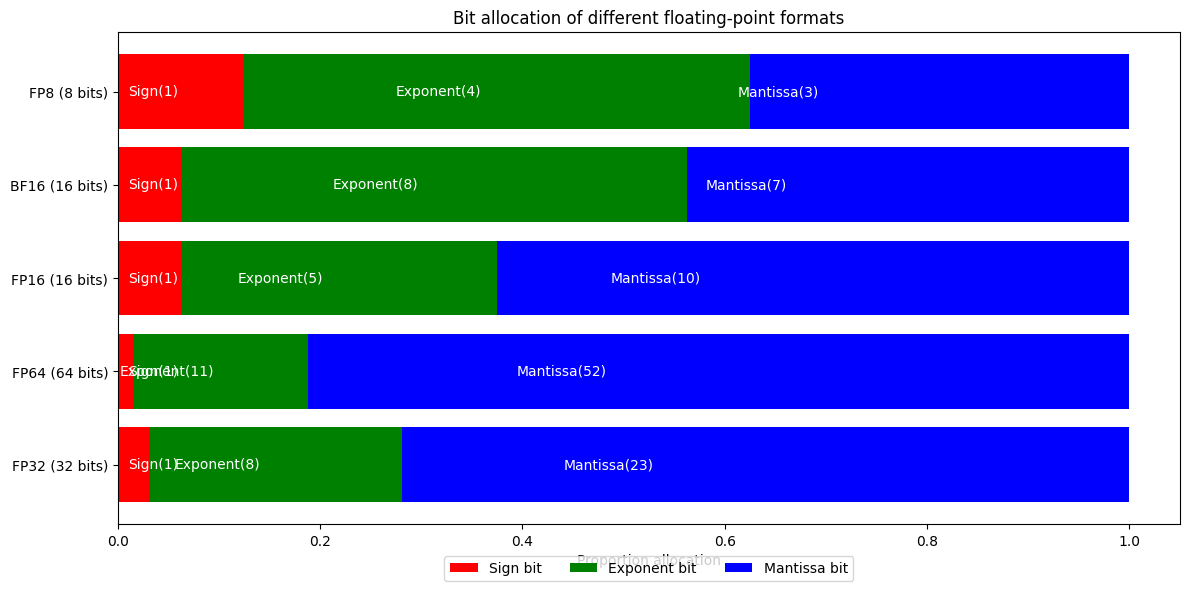

In [3]:
import matplotlib.pyplot as plt


def plot_float_formats():
    formats = [
        {"name": "FP32", "sign": 1, "exponent": 8, "mantissa": 23},
        {"name": "FP64", "sign": 1, "exponent": 11, "mantissa": 52},
        {"name": "FP16", "sign": 1, "exponent": 5, "mantissa": 10},
        {"name": "BF16", "sign": 1, "exponent": 8, "mantissa": 7},
        {"name": "FP8", "sign": 1, "exponent": 4, "mantissa": 3}
    ]

    plt.figure(figsize=(12, 6))

    for i, fmt in enumerate(formats):
        total_bits = fmt["sign"] + fmt["exponent"] + fmt["mantissa"]

        # 计算每部分的比例
        sign_ratio = fmt["sign"] / total_bits
        exp_ratio = fmt["exponent"] / total_bits
        mant_ratio = fmt["mantissa"] / total_bits

        # 绘制水平条形图
        plt.barh(i, sign_ratio, color='red', label='Sign bit' if i == 0 else "")
        plt.barh(i, exp_ratio, left=sign_ratio, color='green', label='Exponent bit' if i == 0 else "")
        plt.barh(i, mant_ratio, left=sign_ratio + exp_ratio, color='blue', label='Mantissa bit' if i == 0 else "")

        # 添加文本标签
        plt.text(0.01, i, f"Sign({fmt['sign']})", va='center', color='white', fontsize=10)
        plt.text(sign_ratio + exp_ratio / 2 - 0.1, i, f"Exponent({fmt['exponent']})", va='center', color='white', fontsize=10)
        plt.text(sign_ratio + exp_ratio + mant_ratio / 2 - 0.2, i, f"Mantissa({fmt['mantissa']})", va='center', color='white', fontsize=10)

    plt.yticks(range(len(formats)), [f"{fmt['name']} ({fmt['sign'] + fmt['exponent'] + fmt['mantissa']} bits)" for fmt in formats])
    plt.xlabel('Proportion allocation')
    plt.title('Bit allocation of different floating-point formats')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    plt.tight_layout()
    plt.show()


plot_float_formats()

2. 数值范围和精度损失演示

In [5]:
def demonstrate_precision_loss():
    # 创建一个大数和一个小数（FP32可以表示，但FP16可能有问题）
    large_num = torch.tensor([65504.0], dtype=torch.float32)  # FP16最大值约为65504
    small_num = torch.tensor([1e-5], dtype=torch.float32)     # 接近FP16最小非零值
    
    # 转换为不同精度
    large_fp16 = large_num.to(torch.float16).to(torch.float32)
    large_bf16 = large_num.to(torch.bfloat16).to(torch.float32) if hasattr(torch, 'bfloat16') else torch.tensor([0.0])
    
    small_fp16 = small_num.to(torch.float16).to(torch.float32)
    small_bf16 = small_num.to(torch.bfloat16).to(torch.float32) if hasattr(torch, 'bfloat16') else torch.tensor([0.0])
    
    # 溢出测试
    overflow_test = torch.tensor([65505.0], dtype=torch.float32)  # 略大于FP16最大值
    overflow_fp16 = overflow_test.to(torch.float16).to(torch.float32)
    
    # 打印结果
    print("大数精度测试:")
    print(f"原始值 (FP32): {large_num.item()}")
    print(f"FP16转换后: {large_fp16.item()} (相对误差: {(large_fp16/large_num - 1).item()*100:.8f}%)")
    if hasattr(torch, 'bfloat16'):
        print(f"BF16转换后: {large_bf16.item()} (相对误差: {(large_bf16/large_num - 1).item()*100:.8f}%)")
    
    print("\n小数精度测试:")
    print(f"原始值 (FP32): {small_num.item()}")
    print(f"FP16转换后: {small_fp16.item()} (相对误差: {(small_fp16/small_num - 1).item()*100:.8f}%)")
    if hasattr(torch, 'bfloat16'):
        print(f"BF16转换后: {small_bf16.item()} (相对误差: {(small_bf16/small_num - 1).item()*100:.8f}%)")
    
    print("\n溢出测试:")
    print(f"原始值 (FP32): {overflow_test.item()}")
    print(f"FP16转换后: {overflow_fp16.item()}")
    
    # 累积误差演示
    print("\n累积误差演示:")
    count = 10000
    fp32_sum = torch.tensor(0.0, dtype=torch.float32)
    fp16_sum = torch.tensor(0.0, dtype=torch.float16)
    small_value = torch.tensor(0.0001, dtype=torch.float32)
    
    for i in range(count):
        fp32_sum += small_value
        fp16_sum += small_value.to(torch.float16)
    
    fp16_sum = fp16_sum.to(torch.float32)
    
    print(f"求和 {count} 次 0.0001:")
    print(f"FP32结果: {fp32_sum.item()}")
    print(f"FP16结果: {fp16_sum.item()}")
    print(f"相对误差: {(fp16_sum/fp32_sum - 1).item()*100:.8f}%")

demonstrate_precision_loss()


大数精度测试:
原始值 (FP32): 65504.0
FP16转换后: 65504.0 (相对误差: 0.00000000%)
BF16转换后: 65536.0 (相对误差: 0.04885197%)

小数精度测试:
原始值 (FP32): 9.999999747378752e-06
FP16转换后: 1.0013580322265625e-05 (相对误差: 0.13580322%)
BF16转换后: 1.0013580322265625e-05 (相对误差: 0.13580322%)

溢出测试:
原始值 (FP32): 65505.0
FP16转换后: 65504.0

累积误差演示:
求和 10000 次 0.0001:
FP32结果: 1.0000535249710083
FP16结果: 0.25
相对误差: -75.00133514%


3. 简单神经网络的混合精度训练

创建一个简单的神经网络模型，展示混合精度训练的基本实现：

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_with_mixed_precision(use_amp=True, epochs=5):
    """使用或不使用混合精度训练简单网络"""
    # 检查可用设备
    use_cuda = torch.cuda.is_available()
    use_mps = torch.backends.mps.is_available()
    device = torch.device("cuda" if use_cuda else "mps" if use_mps else "cpu")
    device_name = "CUDA" if use_cuda else "MPS" if use_mps else "CPU"
    
    print(f"\n训练设备: {device_name}")
    print(f"使用混合精度: {'是' if use_amp else '否'}")

    # 创建合成数据
    batch_size = 64
    input_size = 784
    num_classes = 10
    num_batches = 100
    
    # 创建模型和优化器
    model = SimpleNN(input_size=input_size, output_size=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # 创建梯度缩放器（如果使用AMP且是CUDA设备）
    scaler = None
    if use_amp:
        if use_cuda:
            from torch.cuda.amp import GradScaler, autocast
            scaler = GradScaler()
        elif use_mps:
            # MPS使用不同的混合精度实现
            model = model.to(torch.float16)
            print("注意: MPS使用torch.float16进行混合精度训练")
    
    # 训练时间统计
    training_time = 0
    
    # 训练循环
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        start_time = time.time()
        
        for i in range(num_batches):
            # 生成随机数据
            inputs = torch.randn(batch_size, input_size, device=device)
            targets = torch.randint(0, num_classes, (batch_size,), device=device)
            
            # 根据设备类型处理混合精度
            if use_amp and use_cuda:
                # CUDA自动混合精度
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
            elif use_amp and use_mps:
                # MPS混合精度
                inputs = inputs.to(torch.float16)
                outputs = model(inputs)
                loss = criterion(outputs.float(), targets)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            else:
                # 不使用混合精度
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
            epoch_loss += loss.item()
            
        # 同步设备
        if use_cuda:
            torch.cuda.synchronize()
        elif use_mps:
            torch.mps.synchronize()
            
        end_time = time.time()
        epoch_time = end_time - start_time
        training_time += epoch_time
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f}, Time: {epoch_time:.2f}s")
    
    return training_time

# 比较有无混合精度的训练时间
print("训练不使用混合精度:")
fp32_time = train_with_mixed_precision(use_amp=False)

print("\n训练使用混合精度:")
amp_time = train_with_mixed_precision(use_amp=True)

print(f"\n总体比较:")
print(f"FP32训练总时间: {fp32_time:.2f}秒")
print(f"混合精度训练总时间: {amp_time:.2f}秒")
if amp_time > 0:
    print(f"速度提升: {fp32_time/amp_time:.2f}倍")

训练不使用混合精度:

训练设备: MPS
使用混合精度: 否
Epoch 1/5, Loss: 2.7052, Time: 4.07s
Epoch 2/5, Loss: 6.4871, Time: 0.38s
Epoch 3/5, Loss: 11.2731, Time: 0.39s
Epoch 4/5, Loss: 17.2168, Time: 0.39s
Epoch 5/5, Loss: 21.4082, Time: 1.44s

训练使用混合精度:

训练设备: MPS
使用混合精度: 是
注意: MPS使用torch.float16进行混合精度训练
Epoch 1/5, Loss: nan, Time: 2.07s
Epoch 2/5, Loss: nan, Time: 0.34s
Epoch 3/5, Loss: nan, Time: 0.37s
Epoch 4/5, Loss: nan, Time: 0.36s
Epoch 5/5, Loss: nan, Time: 0.31s

总体比较:
FP32训练总时间: 6.68秒
混合精度训练总时间: 3.44秒
速度提升: 1.94倍


4. 损失缩放演示

原始梯度平均值: 1.0000000656873453e-05
FP16转换后梯度平均值: 1.0013580322265625e-05
使用损失缩放后恢复的梯度平均值: 9.998679161071777e-06
保留的梯度信息: 99.99%


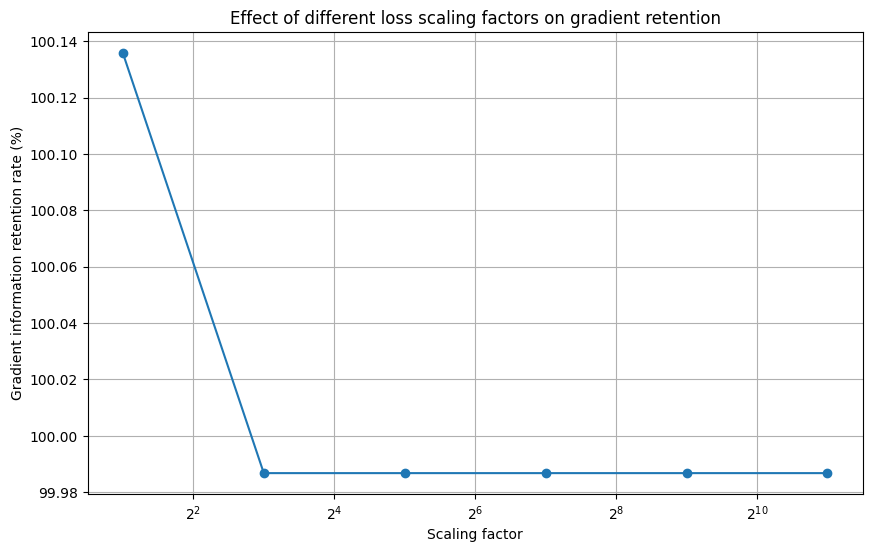

In [9]:
def demonstrate_loss_scaling():
    # 创建一个小梯度示例
    small_gradient = torch.full((1000,), 1e-5, dtype=torch.float32)
    print(f"原始梯度平均值: {small_gradient.mean().item()}")
    
    # 将梯度转换为FP16并返回FP32，模拟混合精度训练中的转换
    grad_fp16 = small_gradient.to(torch.float16).to(torch.float32)
    print(f"FP16转换后梯度平均值: {grad_fp16.mean().item()}")
    
    # 应用损失缩放
    scale_factor = 128
    scaled_gradient = small_gradient * scale_factor
    
    # 转换为FP16再返回FP32
    scaled_grad_fp16 = scaled_gradient.to(torch.float16).to(torch.float32)
    
    # 反向应用缩放因子
    unscaled_grad = scaled_grad_fp16 / scale_factor
    
    print(f"使用损失缩放后恢复的梯度平均值: {unscaled_grad.mean().item()}")
    
    # 计算保留的精度
    retained_percentage = (unscaled_grad.sum() / small_gradient.sum()) * 100
    print(f"保留的梯度信息: {retained_percentage.item():.2f}%")
    
    # 尝试不同的缩放因子
    scale_factors = [2, 8, 32, 128, 512, 2048]
    retention_rates = []
    
    for factor in scale_factors:
        # 应用损失缩放
        scaled_grad = small_gradient * factor
        
        # 模拟FP16 -> FP32转换
        recovered_grad = (scaled_grad.to(torch.float16).to(torch.float32)) / factor
        
        # 计算保留率
        retention = (recovered_grad.sum() / small_gradient.sum()) * 100
        retention_rates.append(retention.item())
    
    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.plot(scale_factors, retention_rates, marker='o')
    plt.xscale('log', base=2)
    # plt.xlabel('缩放因子')
    # plt.ylabel('梯度信息保留率 (%)')
    # plt.title('不同损失缩放因子对梯度保留的影响')
    plt.xscale('log', base=2)
    plt.xlabel('Scaling factor')
    plt.ylabel('Gradient information retention rate (%)')
    plt.title('Effect of different loss scaling factors on gradient retention')
    plt.grid(True)
    plt.show()

demonstrate_loss_scaling()

5. 动态损失缩放实现

Iteration 6: 检测到梯度溢出, 缩放因子减小到 128.0
Iteration 10: 检测到梯度溢出, 缩放因子减小到 64.0
Iteration 29: 检测到梯度溢出, 缩放因子减小到 32.0
Iteration 32: 检测到梯度溢出, 缩放因子减小到 16.0
Iteration 37: 检测到梯度溢出, 缩放因子减小到 8.0
Iteration 40: 检测到梯度溢出, 缩放因子减小到 4.0
Iteration 42: 检测到梯度溢出, 缩放因子减小到 2.0
Iteration 49: 检测到梯度溢出, 缩放因子减小到 1
Iteration 56: 检测到梯度溢出, 缩放因子减小到 1
Iteration 57: 检测到梯度溢出, 缩放因子减小到 1
Iteration 58: 检测到梯度溢出, 缩放因子减小到 1
Iteration 66: 检测到梯度溢出, 缩放因子减小到 1
Iteration 68: 检测到梯度溢出, 缩放因子减小到 1
Iteration 71: 检测到梯度溢出, 缩放因子减小到 1
Iteration 72: 检测到梯度溢出, 缩放因子减小到 1
Iteration 77: 检测到梯度溢出, 缩放因子减小到 1
Iteration 79: 检测到梯度溢出, 缩放因子减小到 1
Iteration 83: 检测到梯度溢出, 缩放因子减小到 1
Iteration 90: 检测到梯度溢出, 缩放因子减小到 1
Iteration 98: 检测到梯度溢出, 缩放因子减小到 1
Iteration 99: 检测到梯度溢出, 缩放因子减小到 1
Iteration 100: 检测到梯度溢出, 缩放因子减小到 1
Iteration 105: 检测到梯度溢出, 缩放因子减小到 1
Iteration 108: 检测到梯度溢出, 缩放因子减小到 1
Iteration 109: 检测到梯度溢出, 缩放因子减小到 1
Iteration 110: 检测到梯度溢出, 缩放因子减小到 1
Iteration 111: 检测到梯度溢出, 缩放因子减小到 1
Iteration 117: 检测到梯度溢出, 缩放因子减小到 1
Iteration 122: 检测到梯度溢出, 缩放因子减小到 1
Iteration 123: 检测

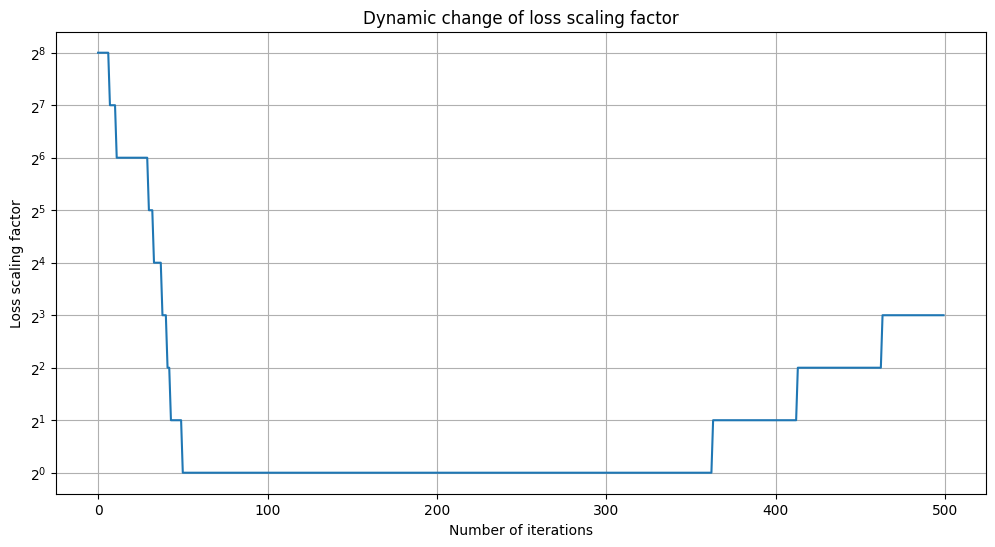

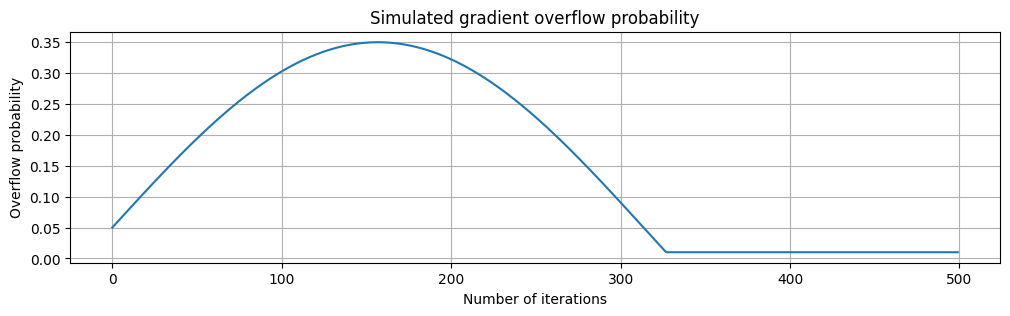

In [11]:
class DynamicLossScaler:
    def __init__(self, init_scale=2**15, scale_factor=2, scale_window=2000):
        self.scale = init_scale
        self.scale_factor = scale_factor
        self.scale_window = scale_window
        self.iter_counter = 0
        self.last_overflow_iter = -1
        self.scale_history = []
    
    def scale_loss(self, loss):
        return loss * self.scale
    
    def check_overflow(self, grad):
        # 检查梯度是否包含NaN或Inf
        return not torch.isfinite(grad).all()
    
    def update_scale(self, overflow):
        self.scale_history.append(self.scale)
        
        if overflow:
            # 梯度溢出，减小缩放因子
            self.scale = max(1, self.scale / self.scale_factor)
            self.last_overflow_iter = self.iter_counter
            print(f"Iteration {self.iter_counter}: 检测到梯度溢出, 缩放因子减小到 {self.scale}")
        elif (self.iter_counter - self.last_overflow_iter) >= self.scale_window:
            # 一段时间没有溢出，增大缩放因子
            self.scale *= self.scale_factor
            self.last_overflow_iter = self.iter_counter
            print(f"Iteration {self.iter_counter}: {self.scale_window}次迭代无溢出, 缩放因子增加到 {self.scale}")
        
        self.iter_counter += 1
        
        return self.scale

def simulate_dynamic_loss_scaling():
    # 模拟训练中的梯度模式
    scaler = DynamicLossScaler(init_scale=256, scale_factor=2, scale_window=50)
    iterations = 500
    
    # 创建一个包含一些随机溢出的序列
    np.random.seed(42)
    overflow_probs = np.clip(0.05 + 0.3 * np.sin(np.linspace(0, 5, iterations)), 0.01, 0.6)
    
    for i in range(iterations):
        # 模拟梯度计算和溢出检测
        overflow = np.random.random() < overflow_probs[i]
        scaler.update_scale(overflow)
    
    # 绘制缩放因子历史
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.scale_history)
    plt.yscale('log', base=2)
    # plt.xlabel('迭代次数')
    # plt.ylabel('损失缩放因子')
    # plt.title('动态损失缩放因子变化')
    plt.xlabel('Number of iterations')
    plt.ylabel('Loss scaling factor')
    plt.title('Dynamic change of loss scaling factor')
    plt.grid(True)
    plt.show()
    
    # 绘制溢出概率
    plt.figure(figsize=(12, 3))
    plt.plot(overflow_probs)
    # plt.xlabel('迭代次数')
    # plt.ylabel('溢出概率')
    # plt.title('模拟的梯度溢出概率')
    plt.xlabel('Number of iterations')
    plt.ylabel('Overflow probability')
    plt.title('Simulated gradient overflow probability')
    plt.grid(True)
    plt.show()

simulate_dynamic_loss_scaling()

6. 精度对模型性能的影响

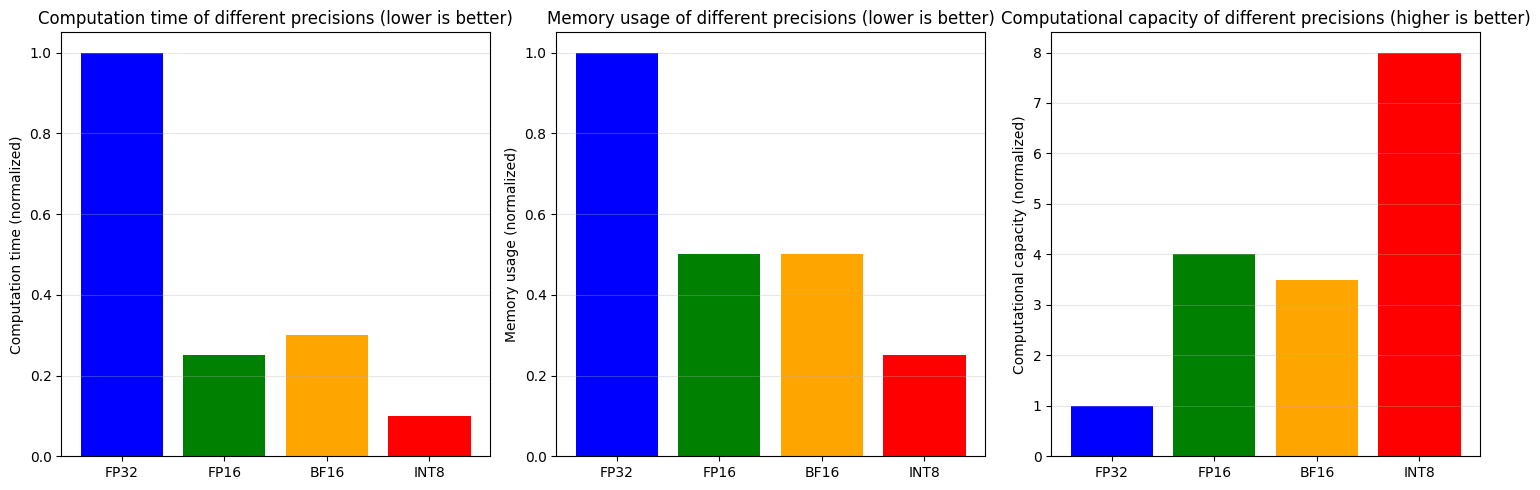

In [13]:
def compare_precision_performance():
    # 模拟不同精度的计算时间和内存使用
    precisions = ["FP32", "FP16", "BF16", "INT8"]
    
    # 归一化的计算时间（相对于FP32）
    compute_time = [1.0, 0.25, 0.3, 0.1]
    
    # 归一化的内存使用（相对于FP32）
    memory_usage = [1.0, 0.5, 0.5, 0.25]
    
    # 模拟的计算能力（相对于FP32）
    compute_capacity = [1.0, 4.0, 3.5, 8.0]
    
    # 绘图
    plt.figure(figsize=(15, 5))
    
    # 计算时间
    # plt.subplot(1, 3, 1)
    # plt.bar(precisions, compute_time, color=['blue', 'green', 'orange', 'red'])
    # plt.ylabel('计算时间（归一化）')
    # plt.title('不同精度的计算时间（越低越好）')
    # plt.grid(True, axis='y', alpha=0.3)
    
    # # 内存使用
    # plt.subplot(1, 3, 2)
    # plt.bar(precisions, memory_usage, color=['blue', 'green', 'orange', 'red'])
    # plt.ylabel('内存使用（归一化）')
    # plt.title('不同精度的内存使用（越低越好）')
    # plt.grid(True, axis='y', alpha=0.3)
    
    # # 计算能力
    # plt.subplot(1, 3, 3)
    # plt.bar(precisions, compute_capacity, color=['blue', 'green', 'orange', 'red'])
    # plt.ylabel('计算能力（归一化）')
    # plt.title('不同精度的计算能力（越高越好）')
    # plt.grid(True, axis='y', alpha=0.3)
    
    # plt.tight_layout()
    # plt.show()
    # Calculate time
    # 计算时间
    plt.subplot(1, 3, 1)
    plt.bar(precisions, compute_time, color=['blue', 'green', 'orange', 'red'])
    plt.ylabel('Computation time (normalized)')
    plt.title('Computation time of different precisions (lower is better)')
    plt.grid(True, axis='y', alpha=0.3)

    # Memory usage
    # 内存使用
    plt.subplot(1, 3, 2)
    plt.bar(precisions, memory_usage, color=['blue', 'green', 'orange', 'red'])
    plt.ylabel('Memory usage (normalized)')
    plt.title('Memory usage of different precisions (lower is better)')
    plt.grid(True, axis='y', alpha=0.3)

    # Computational capacity
    # 计算能力
    plt.subplot(1, 3, 3)
    plt.bar(precisions, compute_capacity, color=['blue', 'green', 'orange', 'red'])
    plt.ylabel('Computational capacity (normalized)')
    plt.title('Computational capacity of different precisions (higher is better)')
    plt.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

compare_precision_performance()

7. 混合精度训练流程可视化

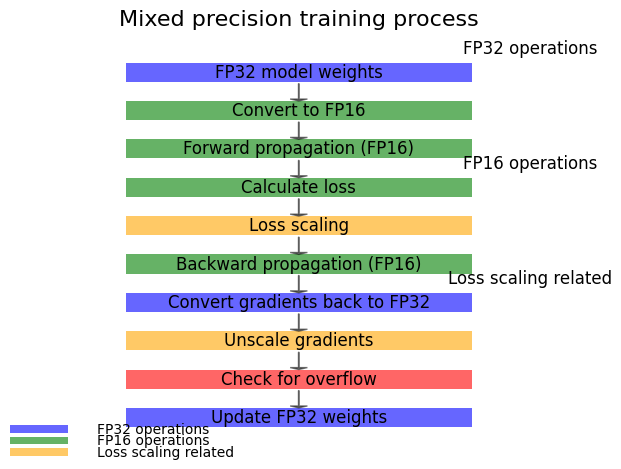

In [15]:
# 定义流程步骤
steps = [
    "FP32 model weights",
    "Convert to FP16",
    "Forward propagation (FP16)",
    "Calculate loss",
    "Loss scaling",
    "Backward propagation (FP16)",
    "Convert gradients back to FP32",
    "Unscale gradients",
    "Check for overflow",
    "Update FP32 weights"
]

# 定义步骤位置
pos_y = np.arange(len(steps), 0, -1)

# 定义颜色
colors = ['blue', 'green', 'green', 'green', 'orange', 
          'green', 'blue', 'orange', 'red', 'blue']

# 绘制水平条
plt.barh(pos_y, [0.6]*len(steps), left=[0.2]*len(steps), 
         color=colors, alpha=0.6, height=0.5)

# 添加步骤文本
for i, (step, y) in enumerate(zip(steps, pos_y)):
    plt.text(0.5, y, step, ha='center', va='center', fontsize=12)

# 添加精度标记
plt.text(0.9, 10.5, "FP32 operations", fontsize=12, ha='center')
plt.text(0.9, 7.5, "FP16 operations", fontsize=12, ha='center')
plt.text(0.9, 4.5, "Loss scaling related", fontsize=12, ha='center')

# 添加颜色图例
plt.barh([0.7], [0.1], color='blue', alpha=0.6, height=0.2)
plt.barh([0.4], [0.1], color='green', alpha=0.6, height=0.2)
plt.barh([0.1], [0.1], color='orange', alpha=0.6, height=0.2)

plt.text(0.15, 0.7, "FP32 operations", va='center')
plt.text(0.15, 0.4, "FP16 operations", va='center')
plt.text(0.15, 0.1, "Loss scaling related", va='center')

# 添加箭头连接各步骤
for y in pos_y[:-1]:
    plt.arrow(0.5, y-0.3, 0, -0.4, 
             head_width=0.03, head_length=0.05, 
             color='black', alpha=0.5)

# 设置图表属性
plt.xlim([0, 1])
plt.ylim([0, len(steps)+1])
plt.axis('off')
plt.title('Mixed precision training process', fontsize=16)
plt.tight_layout()
plt.show()

8. 不同精度对故事生成质量的模拟分析

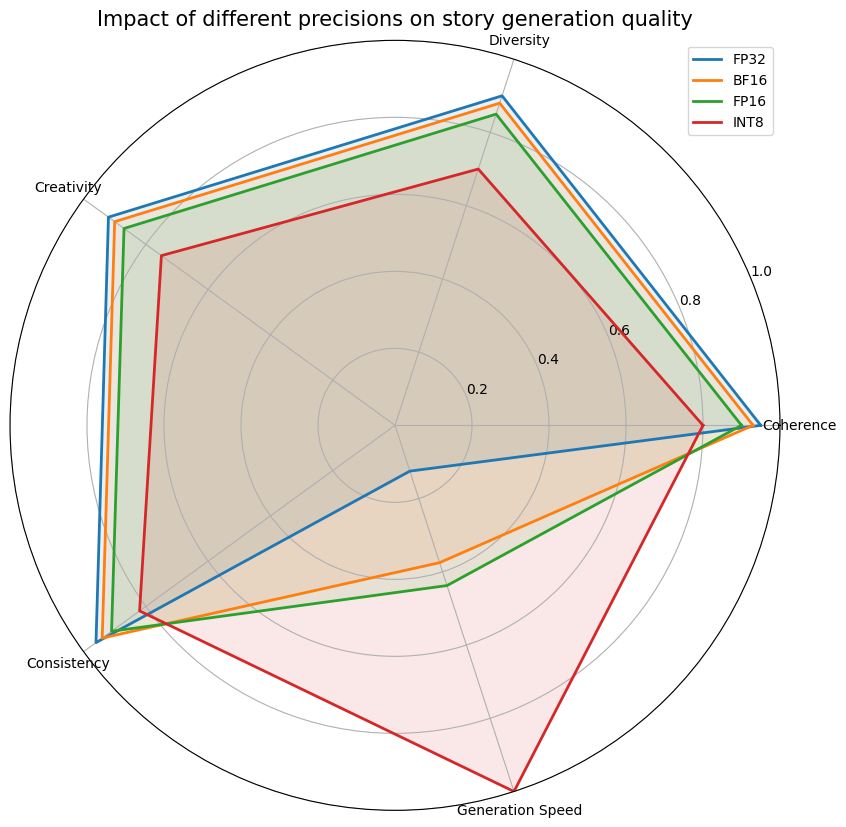

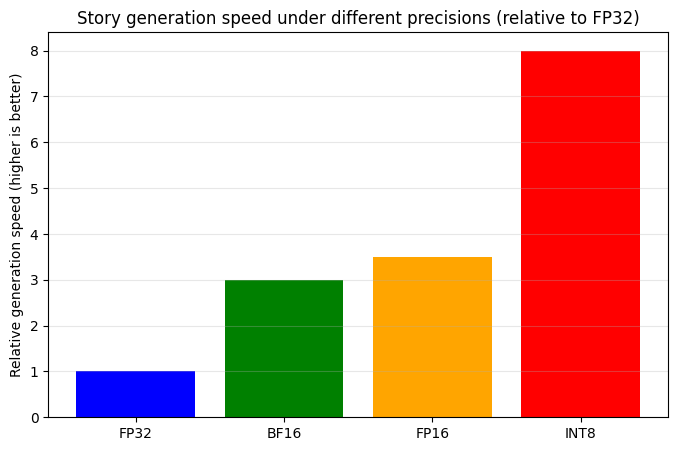

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def simulate_story_generation_quality():
    # 模拟不同精度对故事生成的影响
    precisions = ["FP32", "BF16", "FP16", "INT8"]

    # 模拟指标（这些是示例值，真实情况需要实际测量）
    coherence = [0.95, 0.93, 0.90, 0.80]  # 连贯性
    diversity = [0.90, 0.88, 0.85, 0.70]  # 多样性
    creativity = [0.92, 0.90, 0.87, 0.75]  # 创造性
    consistency = [0.96, 0.94, 0.91, 0.82]  # 一致性
    generation_speed = [1.0, 3.0, 3.5, 8.0]  # 生成速度（相对于FP32）

    # 创建雷达图
    categories = ['Coherence', 'Diversity', 'Creativity', 'Consistency', 'Generation Speed']

    # 将所有值调整为0-1之间，以便在雷达图上表示
    normalized_speed = [s / max(generation_speed) for s in generation_speed]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, polar=True)

    # 添加每个精度格式的数据
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # 闭合雷达图

    # 绘制每种精度的雷达图
    for i, precision in enumerate(precisions):
        values = [coherence[i], diversity[i], creativity[i],
                  consistency[i], normalized_speed[i]]
        values += values[:1]  # 闭合雷达图

        ax.plot(angles, values, linewidth=2, label=precision)
        ax.fill(angles, values, alpha=0.1)

    # 设置雷达图属性
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_ylim(0, 1)
    # 不同精度对故事生成质量的影响
    ax.set_title('Impact of different precisions on story generation quality', fontsize=15)
    ax.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # 生成速度条形图
    plt.figure(figsize=(8, 5))
    plt.bar(precisions, generation_speed, color=['blue', 'green', 'orange', 'red'])
    plt.ylabel('Relative generation speed (higher is better)') # 相对生成速度（越高越好）
    plt.title('Story generation speed under different precisions (relative to FP32)') # 不同精度下的故事生成速度（相对于FP32）
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()


simulate_story_generation_quality()

9. 综合案例：故事生成的混合精度推理


Generating story using FP32 precision...
Generated 500 tokens
Generation time: 5.00 seconds
Generation speed: 100.00 tokens/second
Estimated quality score: 0.89

Generating story using BF16 precision...
Generated 500 tokens
Generation time: 1.67 seconds
Generation speed: 300.00 tokens/second
Estimated quality score: 0.81

Generating story using FP16 precision...
Generated 500 tokens
Generation time: 1.43 seconds
Generation speed: 350.00 tokens/second
Estimated quality score: 0.90

Generating story using INT8 precision...
Generated 500 tokens
Generation time: 0.63 seconds
Generation speed: 800.00 tokens/second
Estimated quality score: 0.67


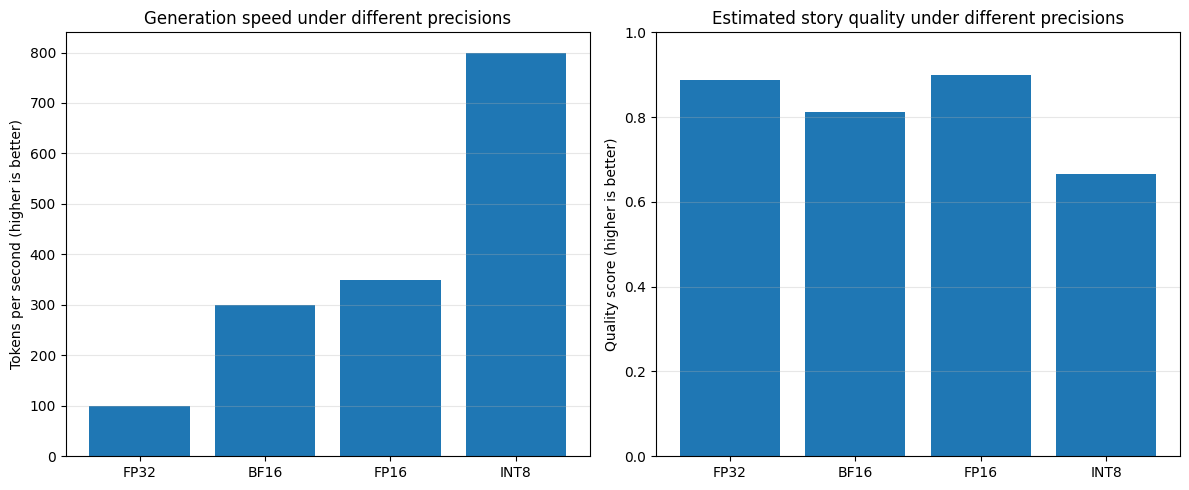

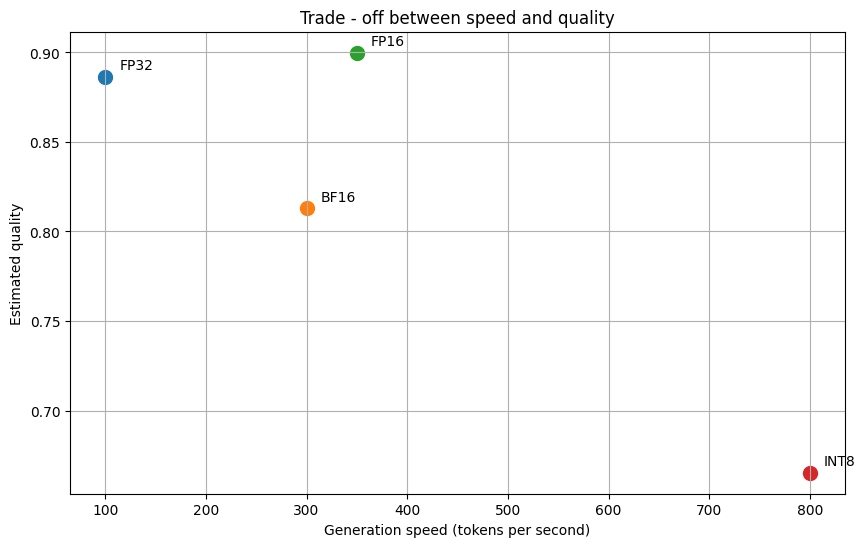

In [17]:
import numpy as np
import time
import matplotlib.pyplot as plt


def simulate_story_generation():
    """模拟不同精度下的故事生成过程"""

    # 模拟故事生成函数
    def generate_story(prompt, precision, tokens=100):
        # 生成一个随机"故事"，长度为tokens个词
        np.random.seed(42 + len(prompt) + len(precision))
        vocab_size = 50000

        # 基于精度设置生成参数
        if precision == "FP32":
            creativity = 0.95
            coherence = 0.95
            speed_factor = 1.0
        elif precision == "BF16":
            creativity = 0.92
            coherence = 0.93
            speed_factor = 3.0
        elif precision == "FP16":
            creativity = 0.90
            coherence = 0.90
            speed_factor = 3.5
        else:  # INT8
            creativity = 0.75
            coherence = 0.80
            speed_factor = 8.0

        # 模拟生成延迟
        delay = (tokens / speed_factor) * 0.01
        time.sleep(delay)

        # 生成"故事" - 实际上只是一个随机词的列表
        # 这里我们简单地用数字替代词，并根据"一致性"参数控制生成的随机性
        story_tokens = []

        prev_token = np.random.randint(0, vocab_size)
        for i in range(tokens):
            # 根据一致性和创造性参数决定下一个词
            if np.random.random() < coherence:
                # 与前一个词相关（模拟连贯性）
                next_token = (prev_token + np.random.randint(-10, 10)) % vocab_size
            else:
                # 完全随机（模拟创造性跳跃）
                if np.random.random() < creativity:
                    next_token = np.random.randint(0, vocab_size)
                else:
                    # 低创造性时重复高频词
                    next_token = np.random.randint(0, 1000)

            story_tokens.append(next_token)
            prev_token = next_token

        # 计算"质量"分数 - 这只是一个模拟
        quality = (creativity * 0.5 + coherence * 0.5) * (0.8 + 0.2 * np.random.random())

        return {
            "tokens": story_tokens,
            "generation_time": delay,
            "tokens_per_second": tokens / delay,
            "estimated_quality": quality
        }

    # 准备测试
    prompt = "Once upon a time, there was a little girl who found a mysterious cottage in the forest."
    precisions = ["FP32", "BF16", "FP16", "INT8"]
    tokens_to_generate = 500

    # 收集结果
    results = []
    for precision in precisions:
        print(f"\nGenerating story using {precision} precision...")
        start_time = time.time()
        result = generate_story(prompt, precision, tokens_to_generate)
        total_time = time.time() - start_time

        print(f"Generated {tokens_to_generate} tokens")
        print(f"Generation time: {total_time:.2f} seconds")
        print(f"Generation speed: {result['tokens_per_second']:.2f} tokens/second")
        print(f"Estimated quality score: {result['estimated_quality']:.2f}")

        result["precision"] = precision
        result["total_time"] = total_time
        results.append(result)

    # 绘制性能比较
    plt.figure(figsize=(12, 5))

    # 速度比较
    plt.subplot(1, 2, 1)
    speeds = [r["tokens_per_second"] for r in results]
    plt.bar(precisions, speeds)
    plt.title("Generation speed under different precisions")
    plt.ylabel("Tokens per second (higher is better)")
    plt.grid(True, axis="y", alpha=0.3)

    # 质量比较
    plt.subplot(1, 2, 2)
    qualities = [r["estimated_quality"] for r in results]
    plt.bar(precisions, qualities)
    plt.title("Estimated story quality under different precisions")
    plt.ylabel("Quality score (higher is better)")
    plt.ylim([0, 1])
    plt.grid(True, axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 计算速度与质量的权衡
    plt.figure(figsize=(10, 6))
    for r in results:
        plt.scatter(r["tokens_per_second"], r["estimated_quality"], s=100)
        plt.annotate(r["precision"],
                     (r["tokens_per_second"], r["estimated_quality"]),
                     xytext=(10, 5), textcoords='offset points')

    plt.xlabel("Generation speed (tokens per second)")
    plt.ylabel("Estimated quality")
    plt.title("Trade - off between speed and quality")
    plt.grid(True)
    plt.show()


simulate_story_generation()

10. 何时使用不同精度的决策流程图

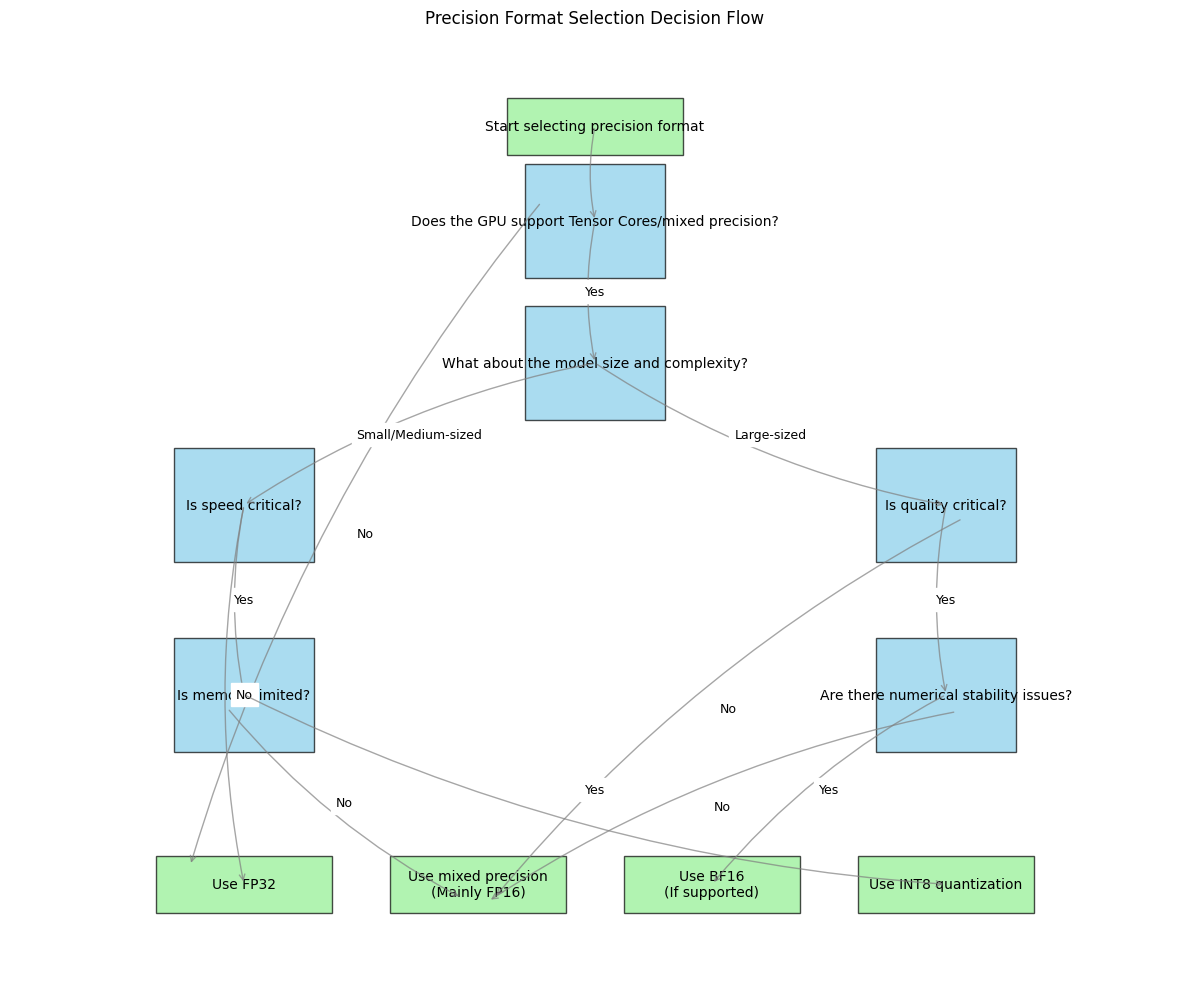

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches


def create_precision_decision_flowchart():
    """创建一个混合精度决策流程图"""
    plt.figure(figsize=(12, 10))

    # 定义节点位置
    nodes = {
        "start": (5, 9),
        "gpu_support": (5, 8),
        "model_size": (5, 6.5),
        "speed_critical": (2, 5),
        "quality_critical": (8, 5),
        "memory_limited": (2, 3),
        "stability_issues": (8, 3),
        "use_fp32": (2, 1),
        "use_mixed_fp16": (4, 1),
        "use_bf16": (6, 1),
        "use_int8": (8, 1),
    }

    # 绘制框和菱形（决策点）
    def draw_box(pos, text, is_decision=False):
        if is_decision:
            # 绘制菱形
            width, height = 1.2, 0.8
            x, y = pos
            diamond = patches.RegularPolygon(
                (x, y), 4, radius=width / 1.414, orientation=np.pi / 4,
                facecolor='skyblue', edgecolor='black', alpha=0.7
            )
            plt.gca().add_patch(diamond)
        else:
            # 绘制矩形
            width, height = 1.5, 0.6
            x, y = pos
            rect = patches.Rectangle(
                (x - width / 2, y - height / 2), width, height,
                facecolor='lightgreen', edgecolor='black', alpha=0.7
            )
            plt.gca().add_patch(rect)

        plt.text(pos[0], pos[1], text, ha='center', va='center', fontsize=10)

    # 绘制箭头
    def draw_arrow(start_pos, end_pos, label="", offset=0):
        x1, y1 = start_pos
        x2, y2 = end_pos

        # 箭头样式
        arrow_props = dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',
                           color='gray', alpha=0.7)

        # 添加偏移以避免线重叠
        if offset != 0:
            dx = x2 - x1
            dy = y2 - y1
            length = np.sqrt(dx * dx + dy * dy)
            dx, dy = dx / length, dy / length

            # 计算垂直方向的偏移
            ox = -dy * offset
            oy = dx * offset

            # 使用偏移点
            x1, y1 = x1 + ox, y1 + oy
            x2, y2 = x2 + ox, y2 + oy

        # 绘制箭头
        plt.annotate("", xy=(x2, y2), xytext=(x1, y1), arrowprops=arrow_props)

        # 添加标签
        if label:
            plt.text((x1 + x2) / 2, (y1 + y2) / 2, label, ha='center', va='center',
                     backgroundcolor='white', fontsize=9)

    # 绘制节点
    # 开始选择精度格式
    draw_box(nodes["start"], "Start selecting precision format", False) 
    # GPU是否支持Tensor Cores/混合精度?
    draw_box(nodes["gpu_support"], "Does the GPU support Tensor Cores/mixed precision?", True) 
    # 模型大小与复杂度?
    draw_box(nodes["model_size"], "What about the model size and complexity?", True)
    # 速度是否关键?
    draw_box(nodes["speed_critical"], "Is speed critical?", True)
    # 质量是否关键?
    draw_box(nodes["quality_critical"], "Is quality critical?", True)
    # 内存是否受限?
    draw_box(nodes["memory_limited"], "Is memory limited?", True)
    # 是否有数值稳定性问题?
    draw_box(nodes["stability_issues"], "Are there numerical stability issues?", True)
    # 使用FP32
    draw_box(nodes["use_fp32"], "Use FP32", False)
    # 使用混合精度\n(主要FP16)
    draw_box(nodes["use_mixed_fp16"], "Use mixed precision\n(Mainly FP16)", False)
    # 使用BF16\n(如果支持)
    draw_box(nodes["use_bf16"], "Use BF16\n(If supported)", False)
    # 使用INT8量化
    draw_box(nodes["use_int8"], "Use INT8 quantization", False)

    # 绘制连接箭头
    draw_arrow(nodes["start"], nodes["gpu_support"])
    draw_arrow(nodes["gpu_support"], nodes["model_size"], "Yes")
    draw_arrow(nodes["gpu_support"], nodes["use_fp32"], "No", offset=-0.5)

    draw_arrow(nodes["model_size"], nodes["speed_critical"], "Small/Medium-sized")
    draw_arrow(nodes["model_size"], nodes["quality_critical"], "Large-sized")

    draw_arrow(nodes["speed_critical"], nodes["memory_limited"], "Yes")
    draw_arrow(nodes["speed_critical"], nodes["use_fp32"], "No")

    draw_arrow(nodes["quality_critical"], nodes["stability_issues"], "Yes")
    draw_arrow(nodes["quality_critical"], nodes["use_mixed_fp16"], "No", offset=0.2)

    draw_arrow(nodes["memory_limited"], nodes["use_int8"], "Yes")
    draw_arrow(nodes["memory_limited"], nodes["use_mixed_fp16"], "No", offset=-0.2)

    draw_arrow(nodes["stability_issues"], nodes["use_bf16"], "Yes")
    draw_arrow(nodes["stability_issues"], nodes["use_mixed_fp16"], "No", offset=0.2)

    # 设置图表属性
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    plt.axis('off')
    plt.title('Precision Format Selection Decision Flow')
    plt.tight_layout()
    plt.show()


create_precision_decision_flowchart()

11. 混合精度对训练收敛的影响

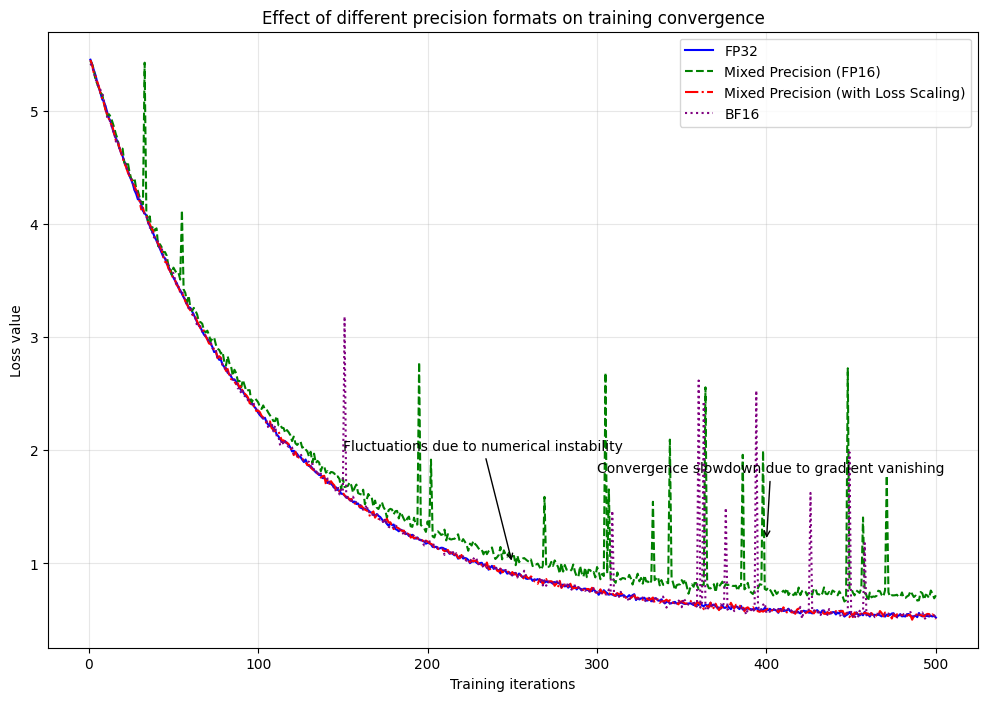

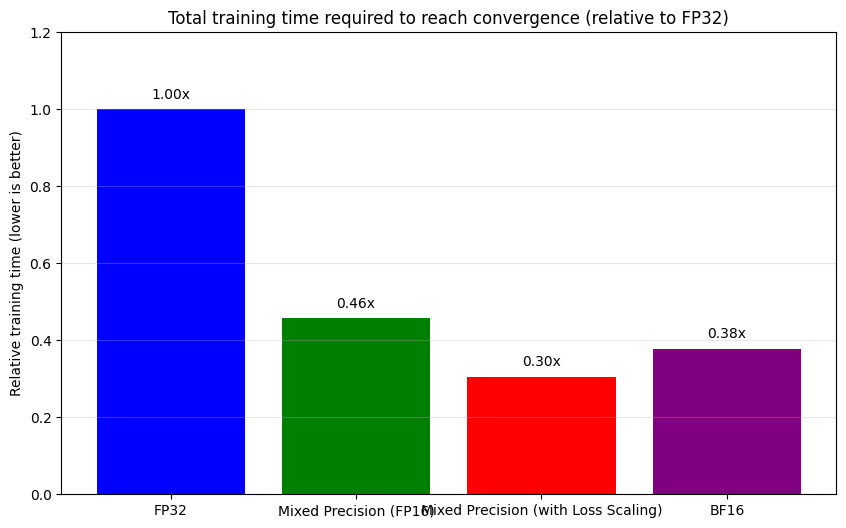

In [21]:
import numpy as np
import matplotlib.pyplot as plt


def simulate_training_convergence():
    """模拟不同精度格式对模型训练收敛的影响"""
    # 设置不同精度训练的模拟参数
    precision_configs = {
        "FP32": {"noise": 0.01, "learning_rate": 0.001, "line_style": "-", "color": "blue"},
        "Mixed Precision (FP16)": {"noise": 0.03, "learning_rate": 0.001, "line_style": "--", "color": "green"},
        "Mixed Precision (with Loss Scaling)": {"noise": 0.015, "learning_rate": 0.001, "line_style": "-.", "color": "red"},
        "BF16": {"noise": 0.02, "learning_rate": 0.001, "line_style": ":", "color": "purple"}
    }

    # 创建训练迭代和理想损失曲线
    iterations = np.arange(1, 501)
    ideal_loss = 5 * np.exp(-0.01 * iterations) + 0.5

    plt.figure(figsize=(12, 8))

    # 为每种精度格式生成模拟的损失曲线
    for precision, config in precision_configs.items():
        # 添加随机噪声，模拟不同精度的影响
        noise_level = config["noise"]
        noise = np.random.normal(0, noise_level, len(iterations))

        # 对于非FP32，有时会出现数值不稳定
        if precision != "FP32" and precision != "Mixed Precision (with Loss Scaling)":
            # 模拟偶尔的数值不稳定导致的损失峰值
            unstable_points = np.random.choice([0, 1], size=len(iterations), p=[0.98, 0.02])
            noise = noise + unstable_points * np.random.uniform(0.5, 2.0, size=len(iterations))

        # 对于没有损失缩放的FP16，模拟梯度消失问题
        if precision == "Mixed Precision (FP16)":
            # 随着训练进行，梯度逐渐变小，进展减缓
            gradient_vanishing = 0.2 * (1 - np.exp(-0.005 * iterations))
            loss = ideal_loss + noise + gradient_vanishing
        else:
            loss = ideal_loss + noise

        # 绘制损失曲线
        plt.plot(iterations, loss,
                 linestyle=config["line_style"],
                 color=config["color"],
                 label=precision)

    # 设置图表属性
    plt.xlabel('Training iterations')
    plt.ylabel('Loss value')
    plt.title('Effect of different precision formats on training convergence')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 添加注释
    plt.annotate('Convergence slowdown due to gradient vanishing', xy=(400, 1.2), xytext=(300, 1.8),
                 arrowprops=dict(arrowstyle="->", color='black'))

    plt.annotate('Fluctuations due to numerical instability', xy=(250, 1.0), xytext=(150, 2.0),
                 arrowprops=dict(arrowstyle="->", color='black'))

    plt.show()

    # 创建收敛速度比较
    iterations_to_converge = {
        "FP32": 350,
        "Mixed Precision (FP16)": 480,
        "Mixed Precision (with Loss Scaling)": 320,
        "BF16": 330
    }

    speedup = {
        "FP32": 1.0,
        "Mixed Precision (FP16)": 3.0,
        "Mixed Precision (with Loss Scaling)": 3.0,
        "BF16": 2.5
    }

    # 计算总训练时间（相对值）
    total_time = {precision: iters / speedup[precision] for precision, iters in iterations_to_converge.items()}

    # 归一化，使FP32为1.0
    normalized_time = {precision: time / total_time["FP32"] for precision, time in total_time.items()}

    # 绘制总训练时间对比
    plt.figure(figsize=(10, 6))
    bars = plt.bar(normalized_time.keys(), normalized_time.values(), color=['blue', 'green', 'red', 'purple'])

    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height + 0.02,
                 f'{height:.2f}x', ha='center', va='bottom')

    plt.ylabel('Relative training time (lower is better)')
    plt.title('Total training time required to reach convergence (relative to FP32)')
    plt.ylim(0, 1.2)
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()


simulate_training_convergence()

12. 不同硬件平台的精度支持和性能对比

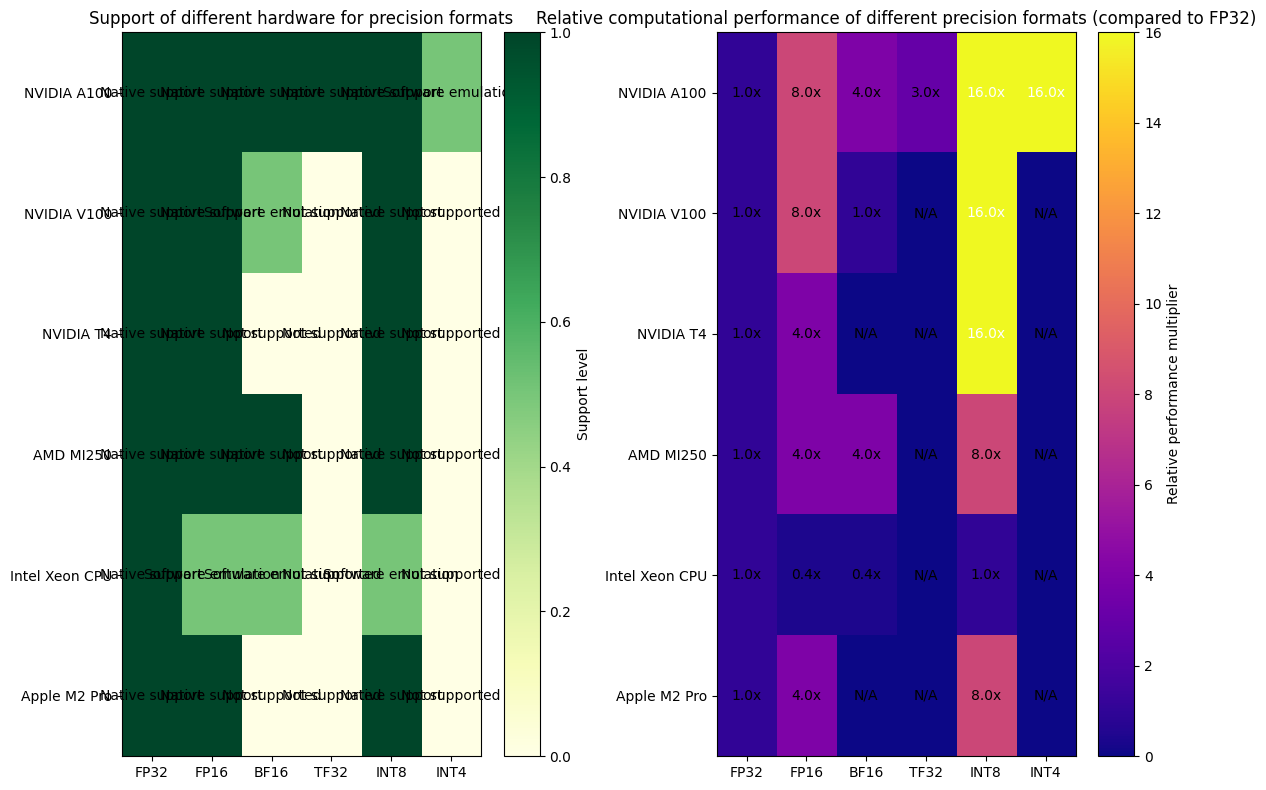

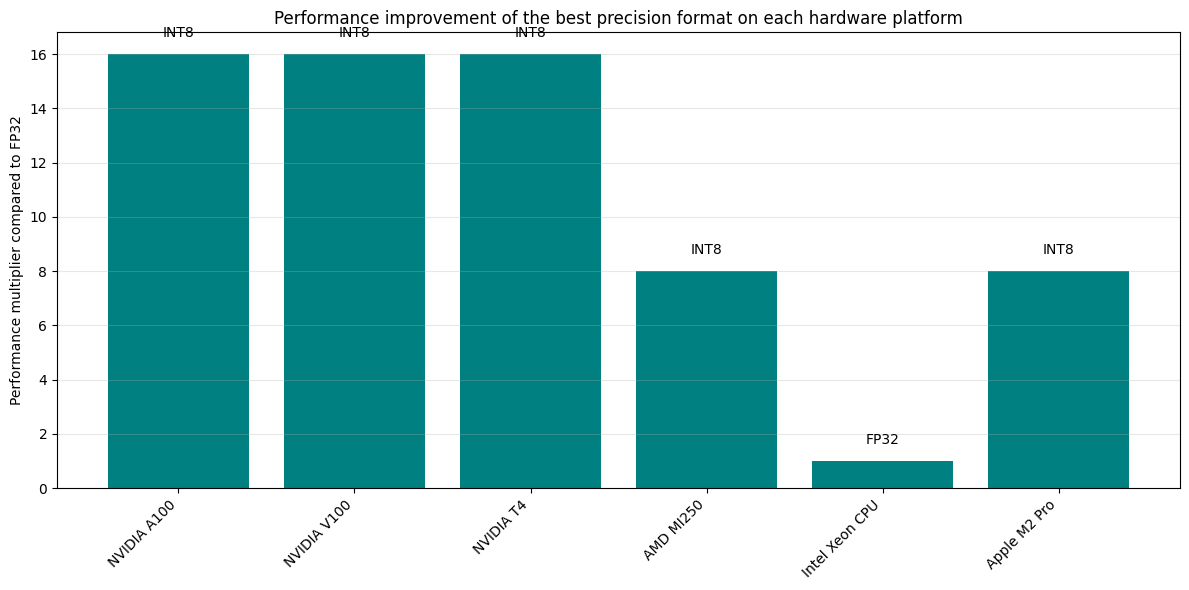

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def compare_hardware_precision_support():
    """比较不同硬件平台对各种精度格式的支持和性能"""
    # 定义硬件平台和精度类型
    hardware = [
        "NVIDIA A100",
        "NVIDIA V100",
        "NVIDIA T4",
        "AMD MI250",
        "Intel Xeon CPU",
        "Apple M2 Pro"
    ]

    precision_formats = ["FP32", "FP16", "BF16", "TF32", "INT8", "INT4"]

    # 硬件对精度的支持矩阵（1表示原生支持，0.5表示通过软件模拟支持，0表示不支持）
    support_matrix = np.array([
        [1, 1, 1, 1, 1, 0.5],  # A100
        [1, 1, 0.5, 0, 1, 0],  # V100
        [1, 1, 0, 0, 1, 0],    # T4
        [1, 1, 1, 0, 1, 0],    # MI250
        [1, 0.5, 0.5, 0, 0.5, 0],  # Xeon CPU
        [1, 1, 0, 0, 1, 0]     # M2 Pro
    ])

    # 相对性能矩阵（相对于FP32的性能比例）
    performance_matrix = np.array([
        [1, 8, 4, 3, 16, 32],     # A100
        [1, 8, 2, 0, 16, 0],      # V100
        [1, 4, 0, 0, 16, 0],      # T4
        [1, 4, 4, 0, 8, 0],       # MI250
        [1, 0.8, 0.8, 0, 2, 0],   # Xeon CPU
        [1, 4, 0, 0, 8, 0]        # M2 Pro
    ])

    # 调整性能矩阵 - 不支持的格式性能为0
    adjusted_performance = performance_matrix * support_matrix

    # 创建热力图显示支持情况
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    support_map = plt.imshow(support_matrix, cmap='YlGn', aspect='auto')
    plt.colorbar(support_map, label='Support level')
    plt.xticks(np.arange(len(precision_formats)), precision_formats)
    plt.yticks(np.arange(len(hardware)), hardware)
    plt.title('Support of different hardware for precision formats')

    # 在单元格中添加数值
    for i in range(len(hardware)):
        for j in range(len(precision_formats)):
            support_level = support_matrix[i, j]
            if support_level == 1:
                text = "Native support"
            elif support_level == 0.5:
                text = "Software emulation"
            else:
                text = "Not supported"
            plt.text(j, i, text, ha="center", va="center", color="black")

    # 创建性能比较热力图
    plt.subplot(1, 2, 2)
    perf_map = plt.imshow(adjusted_performance, cmap='plasma', aspect='auto')
    plt.colorbar(perf_map, label='Relative performance multiplier')
    plt.xticks(np.arange(len(precision_formats)), precision_formats)
    plt.yticks(np.arange(len(hardware)), hardware)
    plt.title('Relative computational performance of different precision formats (compared to FP32)')

    # 在单元格中添加数值
    for i in range(len(hardware)):
        for j in range(len(precision_formats)):
            perf = adjusted_performance[i, j]
            if perf > 0:
                plt.text(j, i, f"{perf:.1f}x", ha="center", va="center",
                         color="white" if perf > 8 else "black")
            else:
                plt.text(j, i, "N/A", ha="center", va="center", color="black")

    plt.tight_layout()
    plt.show()

    # 创建速度比较条形图 - 每个硬件平台最佳精度vs FP32
    plt.figure(figsize=(12, 6))

    best_performance = np.max(adjusted_performance, axis=1)
    best_precision = [precision_formats[np.argmax(adjusted_performance[i])] for i in range(len(hardware))]

    bars = plt.bar(hardware, best_performance, color='teal')

    # 添加最佳精度标签
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
                 f'{best_precision[i]}', ha='center', va='bottom')

    plt.ylabel('Performance multiplier compared to FP32')
    plt.title('Performance improvement of the best precision format on each hardware platform')
    plt.grid(True, axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


compare_hardware_precision_support()

3. 混合精度编程模型比较

In [24]:
!pip install apex

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 775.4 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.8/709.8 kB 3.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.3/247.3 kB 3.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3

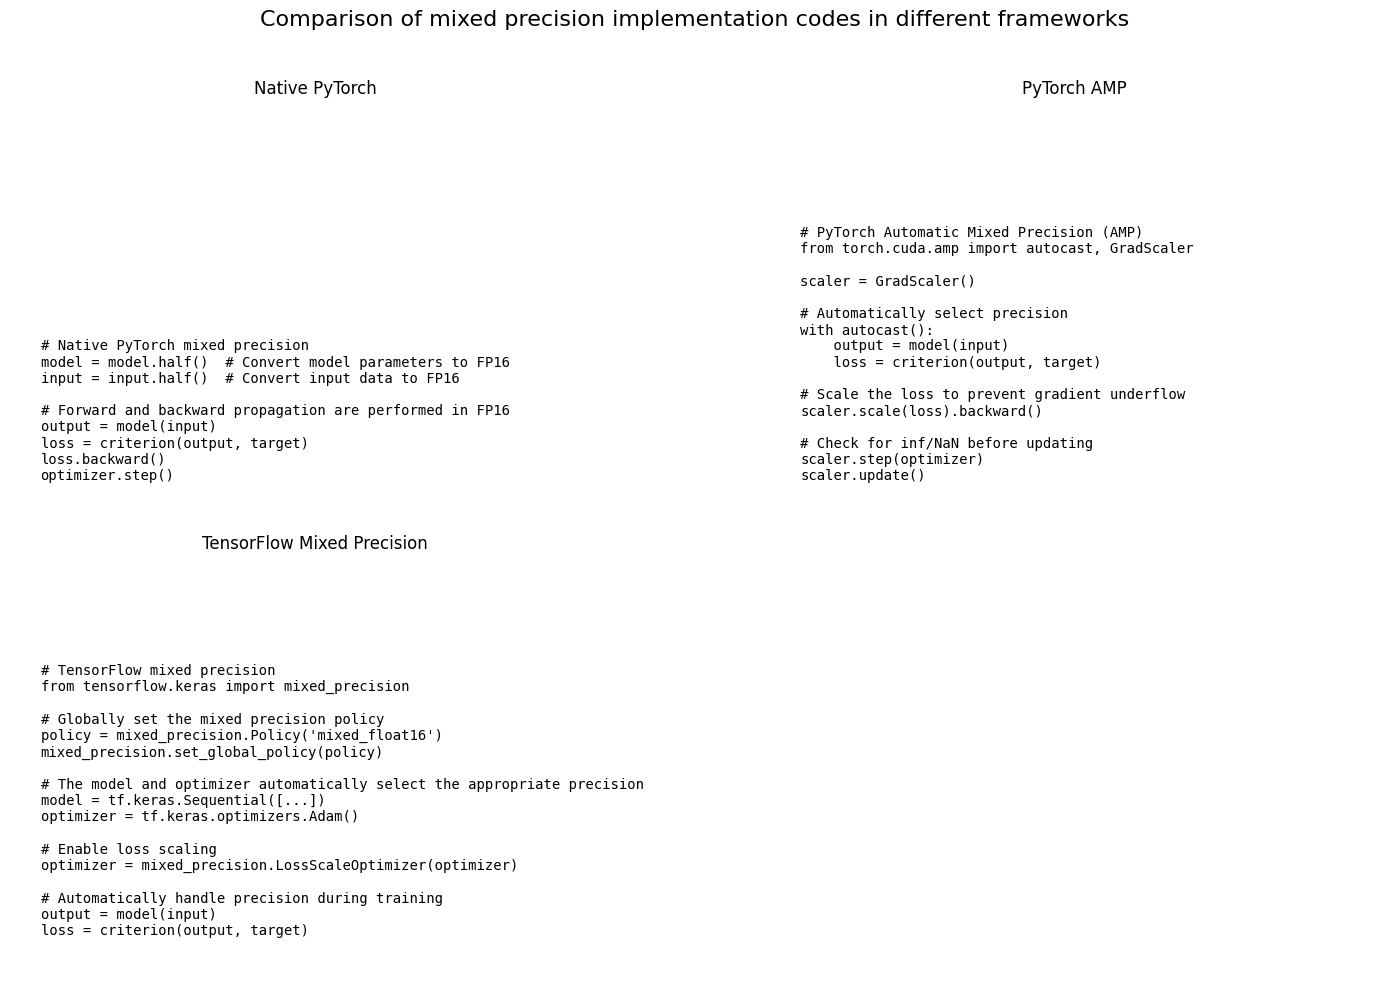

TypeError: 'dict_keys' object is not subscriptable

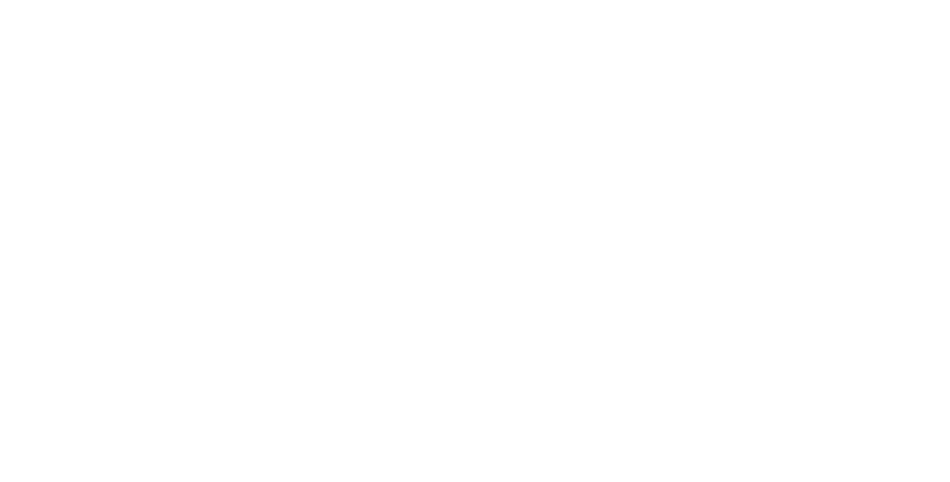

In [27]:

# import matplotlib.pyplot as plt
# import tensorflow as tf
# import torch
# from torch.cuda.amp import autocast, GradScaler
# # import apex
# from apex import amp


# def compare_mixed_precision_frameworks():
#     """比较不同框架和API中的混合精度实现方式"""
#     code_samples = {
#         "Native PyTorch": """
# # Native PyTorch mixed precision
# model = model.half()  # Convert model parameters to FP16
# input = input.half()  # Convert input data to FP16

# # Forward and backward propagation are performed in FP16
# output = model(input)
# loss = criterion(output, target)
# loss.backward()
# optimizer.step()
#         """,

#         "PyTorch AMP": """
# # PyTorch Automatic Mixed Precision (AMP)
# from torch.cuda.amp import autocast, GradScaler

# scaler = GradScaler()

# # Automatically select precision
# with autocast():
#     output = model(input)
#     loss = criterion(output, target)

# # Scale the loss to prevent gradient underflow
# scaler.scale(loss).backward()

# # Check for inf/NaN before updating
# scaler.step(optimizer)
# scaler.update()
#         """,

#         "TensorFlow Mixed Precision": """
# # TensorFlow mixed precision
# from tensorflow.keras import mixed_precision

# # Globally set the mixed precision policy
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

# # The model and optimizer automatically select the appropriate precision
# model = tf.keras.Sequential([...])
# optimizer = tf.keras.optimizers.Adam()

# # Enable loss scaling
# optimizer = mixed_precision.LossScaleOptimizer(optimizer)

# # Automatically handle precision during training
# output = model(input)
# loss = criterion(output, target)
#         """,

#         "NVIDIA APEX": """
# # NVIDIA APEX mixed precision
# import apex
# from apex import amp

# # Initialize the model and optimizer for mixed precision
# model, optimizer = amp.initialize(
#     model, optimizer, opt_level="O1"
# )

# output = model(input)
# loss = criterion(output, target)

# # Use amp for backward propagation
# with amp.scale_loss(loss, optimizer) as scaled_loss:
#     scaled_loss.backward()

# optimizer.step()
#         """
#     }

#     # 创建框架比较表格
#     framework_features = {
#         "Framework/API": ["Native PyTorch", "PyTorch AMP", "TensorFlow Mixed Precision", "NVIDIA APEX"],
#         "Automatic Type Conversion": ["No", "Yes", "Yes", "Yes"],
#         "Dynamic Loss Scaling": ["No", "Yes", "Yes", "Yes"],
#         "Supported Precisions": ["FP16", "FP16/BF16", "FP16/BF16", "FP16"],
#         "Ease of Use": ["Complex", "Simple", "Simple", "Medium"],
#         "Customization Control": ["High", "Medium", "Low", "High"],
#         "Performance Optimization": ["Manual", "Automatic", "Automatic", "Automatic"]
#     }

#     # 创建代码示例图
#     plt.figure(figsize=(14, 10))

#     for i, (name, code) in enumerate(code_samples.items()):
#         plt.subplot(2, 2, i + 1)
#         plt.text(0.05, 0.05, code, fontsize=10, family='monospace', verticalalignment='bottom')
#         plt.title(name)
#         plt.axis('off')
#         plt.gca().set_facecolor('#f0f0f0')

#     plt.suptitle('Comparison of mixed precision implementation codes in different frameworks', fontsize=16)
#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()

#     # 显示特性对比
#     fig = plt.figure(figsize=(12, 6))
#     ax = fig.add_subplot(111)
#     ax.axis('off')
#     table = ax.table(
#         cellText=[[framework_features[key][i] for key in framework_features.keys()]
#                   for i in range(len(framework_features["Framework/API"]))],
#         colLabels=framework_features.keys(),
#         loc='center',
#         cellLoc='center'
#     )
#     table.auto_set_font_size(False)
#     table.set_fontsize(10)
#     table.scale(1, 1.5)

#     plt.title('Comparison of mixed precision framework features')
#     plt.tight_layout()
#     plt.show()


# compare_mixed_precision_frameworks()

import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from torch.cuda.amp import autocast, GradScaler

def compare_mixed_precision_frameworks():
    """比较不同框架和API中的混合精度实现方式"""
    code_samples = {
        "Native PyTorch": """
# Native PyTorch mixed precision
model = model.half()  # Convert model parameters to FP16
input = input.half()  # Convert input data to FP16

# Forward and backward propagation are performed in FP16
output = model(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()
        """,

        "PyTorch AMP": """
# PyTorch Automatic Mixed Precision (AMP)
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Automatically select precision
with autocast():
    output = model(input)
    loss = criterion(output, target)

# Scale the loss to prevent gradient underflow
scaler.scale(loss).backward()

# Check for inf/NaN before updating
scaler.step(optimizer)
scaler.update()
        """,

        "TensorFlow Mixed Precision": """
# TensorFlow mixed precision
from tensorflow.keras import mixed_precision

# Globally set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# The model and optimizer automatically select the appropriate precision
model = tf.keras.Sequential([...])
optimizer = tf.keras.optimizers.Adam()

# Enable loss scaling
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

# Automatically handle precision during training
output = model(input)
loss = criterion(output, target)
        """
    }

    # 创建框架比较表格
    framework_features = {
        "Framework/API": ["Native PyTorch", "PyTorch AMP", "TensorFlow Mixed Precision"],
        "Automatic Type Conversion": ["No", "Yes", "Yes"],
        "Dynamic Loss Scaling": ["No", "Yes", "Yes"],
        "Supported Precisions": ["FP16", "FP16/BF16", "FP16/BF16"],
        "Ease of Use": ["Complex", "Simple", "Simple"],
        "Customization Control": ["High", "Medium", "Low"],
        "Performance Optimization": ["Manual", "Automatic", "Automatic"]
    }

    # 创建代码示例图
    plt.figure(figsize=(14, 10))

    for i, (name, code) in enumerate(code_samples.items()):
        plt.subplot(2, 2, i + 1)
        plt.text(0.05, 0.05, code, fontsize=10, family='monospace', verticalalignment='bottom')
        plt.title(name)
        plt.axis('off')
        plt.gca().set_facecolor('#f0f0f0')

    plt.suptitle('Comparison of mixed precision implementation codes in different frameworks', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 显示特性对比
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.axis('off')
    table = ax.table(
        cellText=[[framework_features[key][i] for key in framework_features.keys()]
                  for i in range(len(framework_features["Framework/API"]))],
        colLabels=framework_features.keys(),
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title('Comparison of mixed precision framework features')
    plt.tight_layout()
    plt.show()

compare_mixed_precision_frameworks()

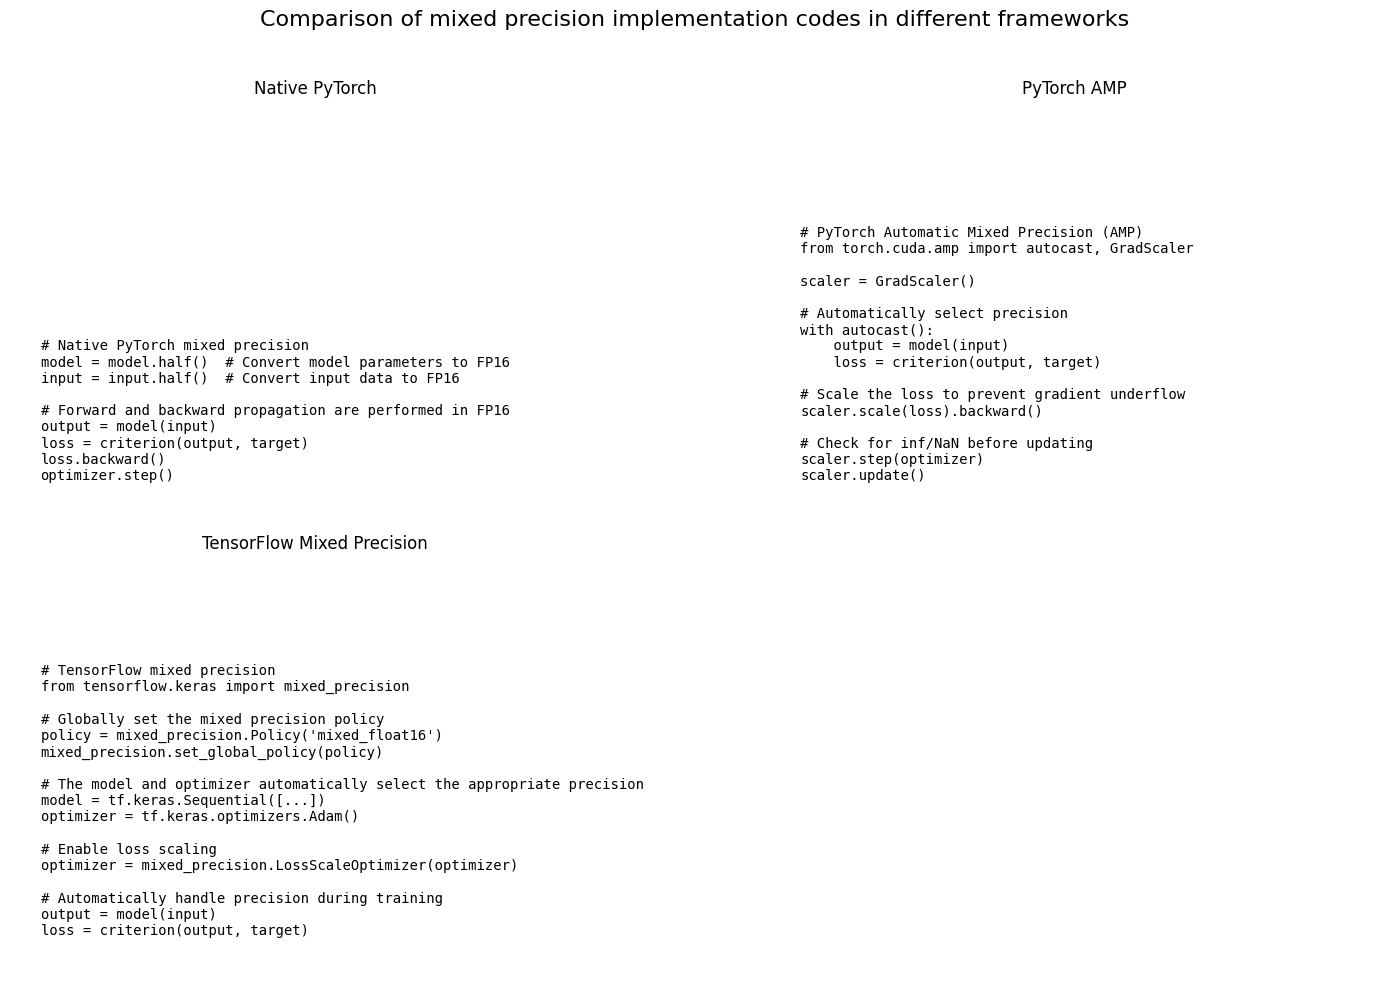

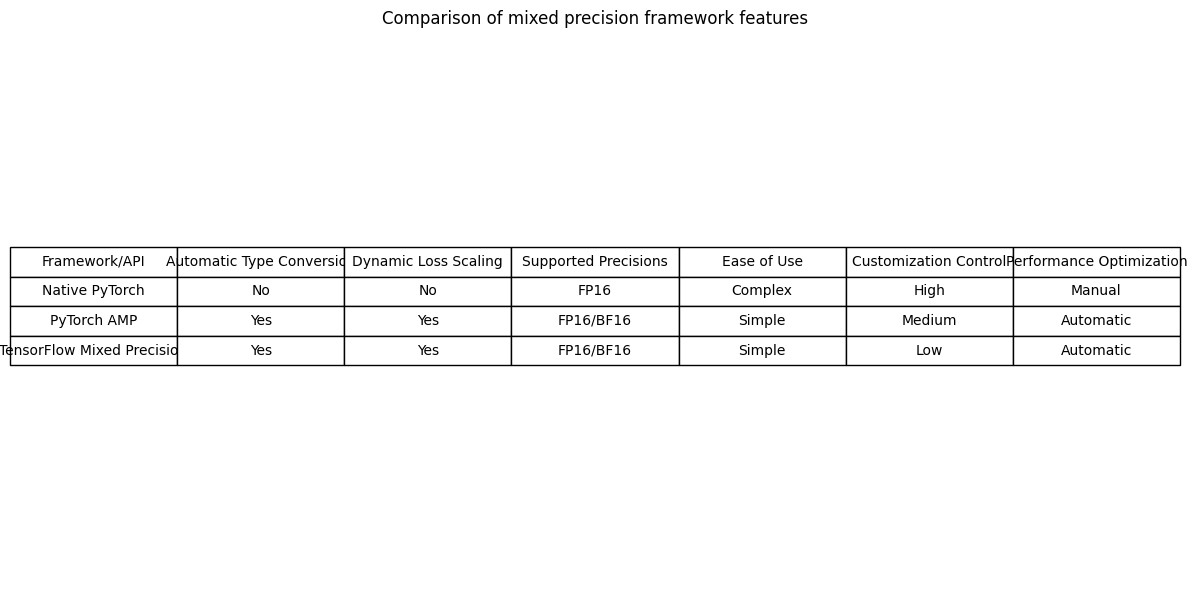

In [28]:
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from torch.cuda.amp import autocast, GradScaler

def compare_mixed_precision_frameworks():
    """比较不同框架和API中的混合精度实现方式"""
    code_samples = {
        "Native PyTorch": """
# Native PyTorch mixed precision
model = model.half()  # Convert model parameters to FP16
input = input.half()  # Convert input data to FP16

# Forward and backward propagation are performed in FP16
output = model(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()
        """,

        "PyTorch AMP": """
# PyTorch Automatic Mixed Precision (AMP)
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

# Automatically select precision
with autocast():
    output = model(input)
    loss = criterion(output, target)

# Scale the loss to prevent gradient underflow
scaler.scale(loss).backward()

# Check for inf/NaN before updating
scaler.step(optimizer)
scaler.update()
        """,

        "TensorFlow Mixed Precision": """
# TensorFlow mixed precision
from tensorflow.keras import mixed_precision

# Globally set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# The model and optimizer automatically select the appropriate precision
model = tf.keras.Sequential([...])
optimizer = tf.keras.optimizers.Adam()

# Enable loss scaling
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

# Automatically handle precision during training
output = model(input)
loss = criterion(output, target)
        """
    }

    # 创建框架比较表格
    framework_features = {
        "Framework/API": ["Native PyTorch", "PyTorch AMP", "TensorFlow Mixed Precision"],
        "Automatic Type Conversion": ["No", "Yes", "Yes"],
        "Dynamic Loss Scaling": ["No", "Yes", "Yes"],
        "Supported Precisions": ["FP16", "FP16/BF16", "FP16/BF16"],
        "Ease of Use": ["Complex", "Simple", "Simple"],
        "Customization Control": ["High", "Medium", "Low"],
        "Performance Optimization": ["Manual", "Automatic", "Automatic"]
    }

    # 创建代码示例图
    plt.figure(figsize=(14, 10))

    for i, (name, code) in enumerate(code_samples.items()):
        plt.subplot(2, 2, i + 1)
        plt.text(0.05, 0.05, code, fontsize=10, family='monospace', verticalalignment='bottom')
        plt.title(name)
        plt.axis('off')
        plt.gca().set_facecolor('#f0f0f0')

    plt.suptitle('Comparison of mixed precision implementation codes in different frameworks', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 显示特性对比
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    # 将dict.keys()转换为列表
    keys = list(framework_features.keys())
    table = ax.table(
        cellText=[[framework_features[key][i] for key in keys]
                  for i in range(len(framework_features["Framework/API"]))],
        colLabels=keys,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title('Comparison of mixed precision framework features')
    plt.tight_layout()
    plt.show()

compare_mixed_precision_frameworks()

14. 混合精度常见问题与解决方案

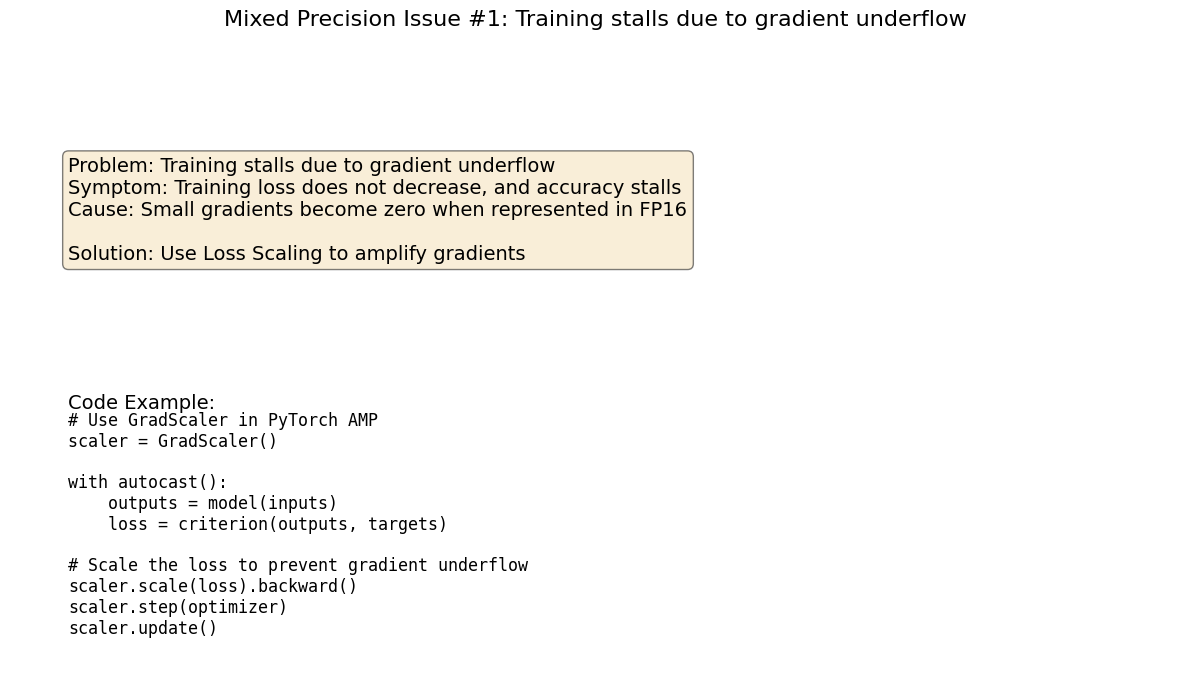

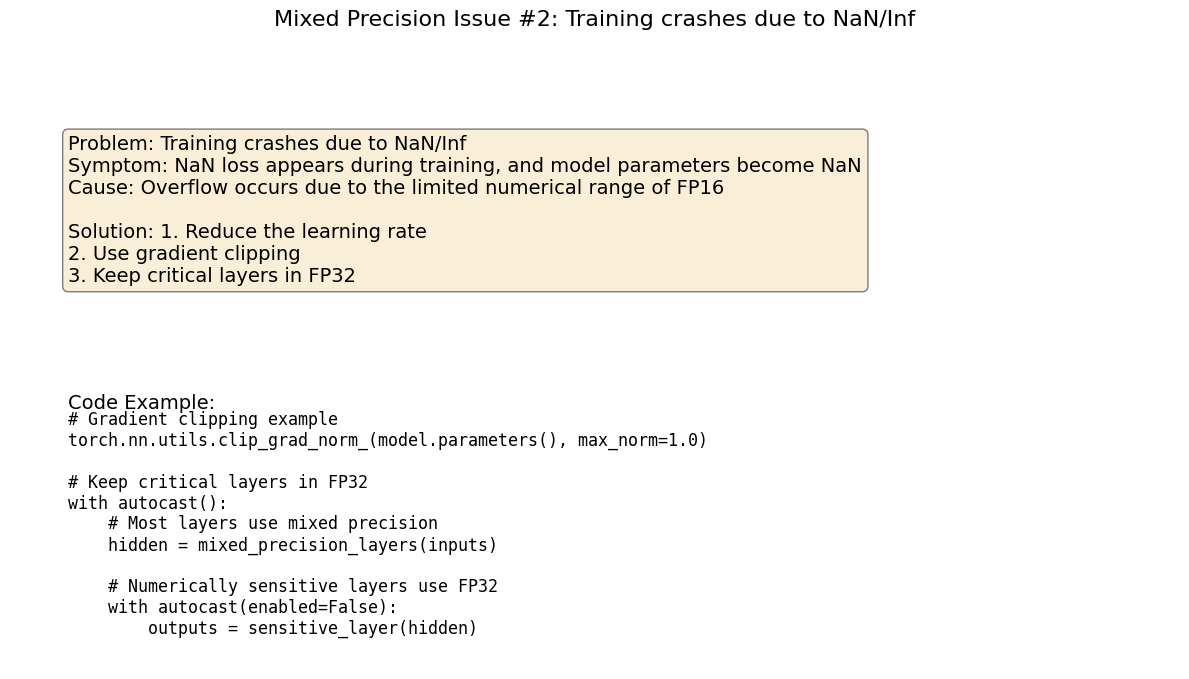

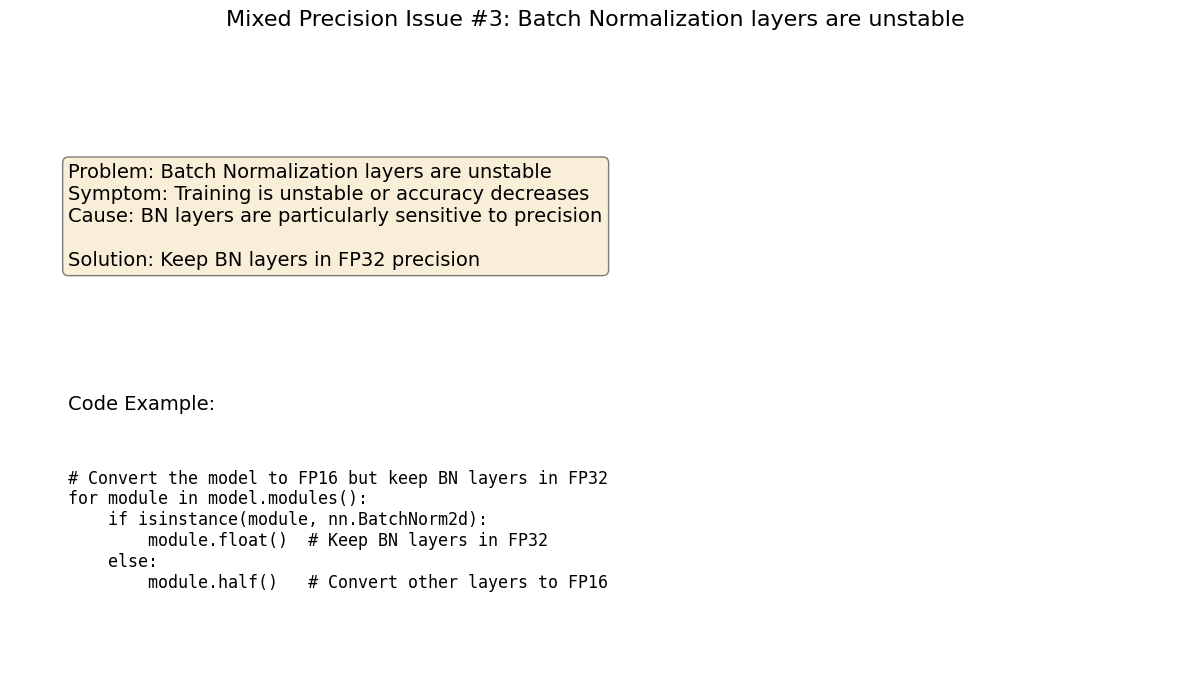

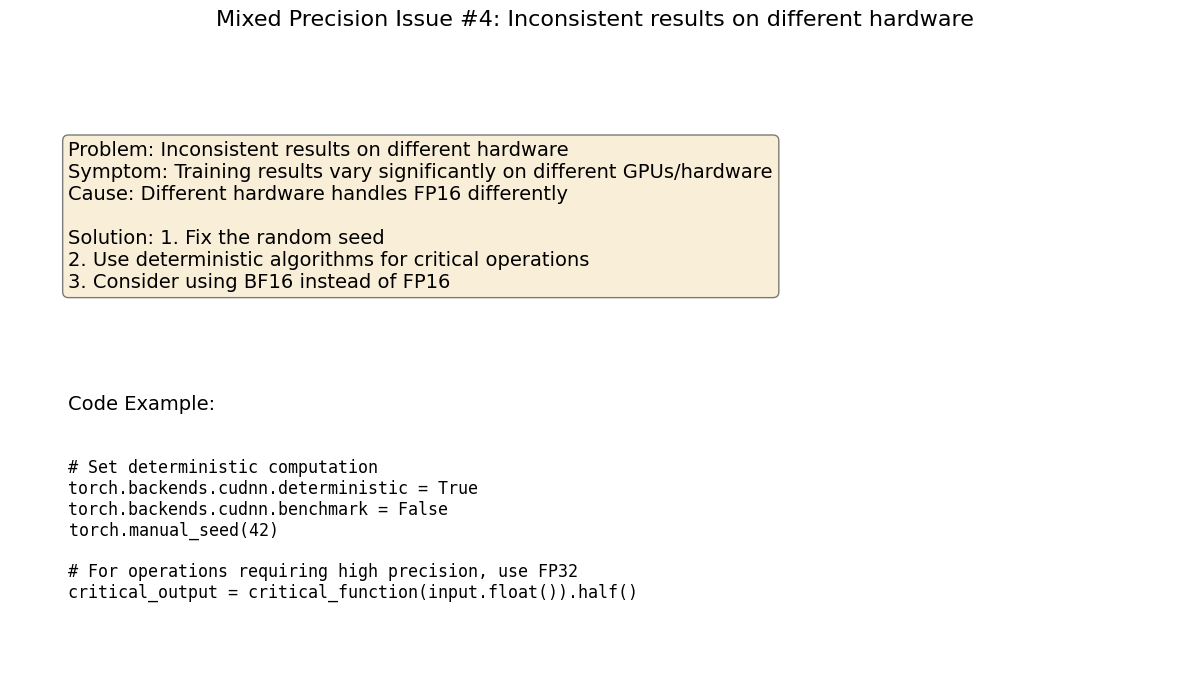

In [29]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt


def common_issues_and_solutions():
    """展示混合精度训练中的常见问题和解决方案"""

    issues_solutions = [
        {
            "Problem": "Training stalls due to gradient underflow",
            "Symptom": "Training loss does not decrease, and accuracy stalls",
            "Cause": "Small gradients become zero when represented in FP16",
            "Solution": "Use Loss Scaling to amplify gradients",
            "Code Example": """
# Use GradScaler in PyTorch AMP
scaler = GradScaler()

with autocast():
    outputs = model(inputs)
    loss = criterion(outputs, targets)

# Scale the loss to prevent gradient underflow
scaler.scale(loss).backward()
scaler.step(optimizer)
scaler.update()
            """
        },
        {
            "Problem": "Training crashes due to NaN/Inf",
            "Symptom": "NaN loss appears during training, and model parameters become NaN",
            "Cause": "Overflow occurs due to the limited numerical range of FP16",
            "Solution": "1. Reduce the learning rate\n2. Use gradient clipping\n3. Keep critical layers in FP32",
            "Code Example": """
# Gradient clipping example
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Keep critical layers in FP32
with autocast():
    # Most layers use mixed precision
    hidden = mixed_precision_layers(inputs)
    
    # Numerically sensitive layers use FP32
    with autocast(enabled=False):
        outputs = sensitive_layer(hidden)
            """
        },
        {
            "Problem": "Batch Normalization layers are unstable",
            "Symptom": "Training is unstable or accuracy decreases",
            "Cause": "BN layers are particularly sensitive to precision",
            "Solution": "Keep BN layers in FP32 precision",
            "Code Example": """
# Convert the model to FP16 but keep BN layers in FP32
for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.float()  # Keep BN layers in FP32
    else:
        module.half()   # Convert other layers to FP16
            """
        },
        {
            "Problem": "Inconsistent results on different hardware",
            "Symptom": "Training results vary significantly on different GPUs/hardware",
            "Cause": "Different hardware handles FP16 differently",
            "Solution": "1. Fix the random seed\n2. Use deterministic algorithms for critical operations\n3. Consider using BF16 instead of FP16",
            "Code Example": """
# Set deterministic computation
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

# For operations requiring high precision, use FP32
critical_output = critical_function(input.float()).half()
            """
        }
    ]

    # 为每个问题创建一个图表
    for i, issue in enumerate(issues_solutions):
        plt.figure(figsize=(12, 7))

        # 创建一个带边框的文本框
        plt.subplot(2, 1, 1)
        textstr = (
            f"Problem: {issue['Problem']}\n"
            f"Symptom: {issue['Symptom']}\n"
            f"Cause: {issue['Cause']}\n\n"
            f"Solution: {issue['Solution']}"
        )

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.05, 0.5, textstr, transform=plt.gca().transAxes, fontsize=14,
                 verticalalignment='center', bbox=props)
        plt.axis('off')

        # 显示代码示例
        plt.subplot(2, 1, 2)
        plt.text(0.05, 0.9, "Code Example:", fontsize=14)
        plt.text(0.05, 0.5, issue['Code Example'], fontsize=12, family='monospace',
                 verticalalignment='center')
        plt.axis('off')
        plt.gca().set_facecolor('#f0f0f0')

        plt.tight_layout()
        plt.suptitle(f"Mixed Precision Issue #{i + 1}: {issue['Problem']}", fontsize=16, y=0.98)
        plt.subplots_adjust(top=0.9)
        plt.show()


common_issues_and_solutions()

15. 混合精度最佳实践总结

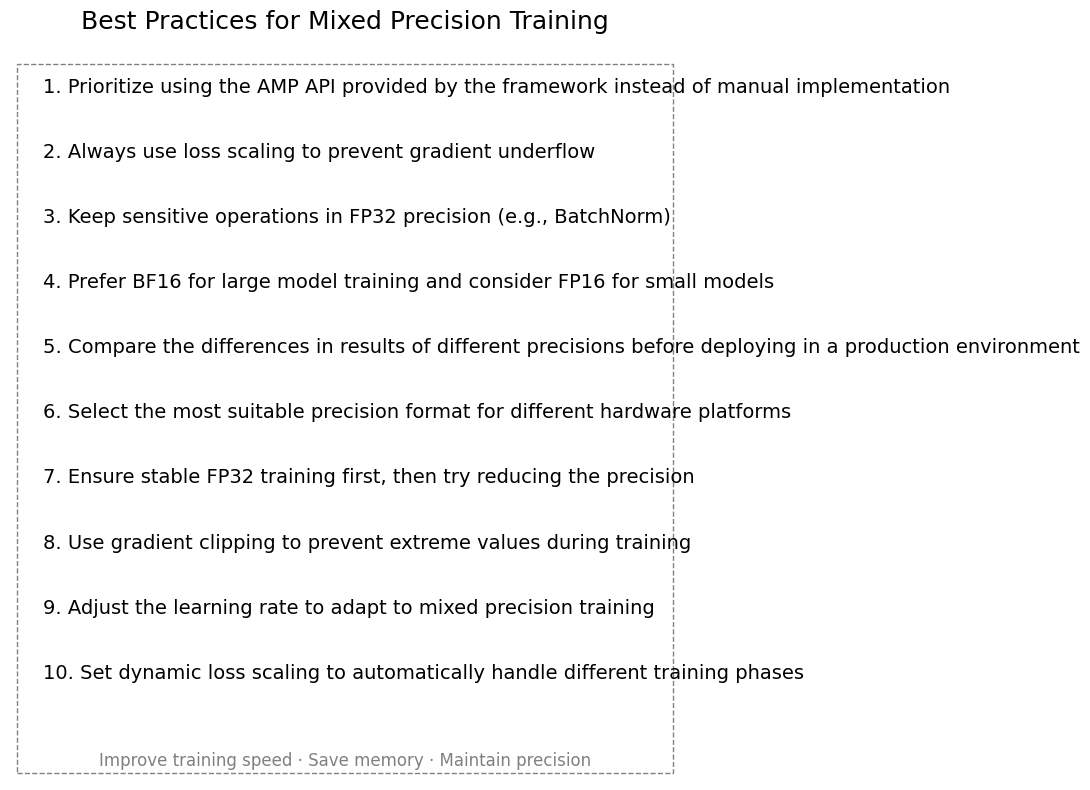

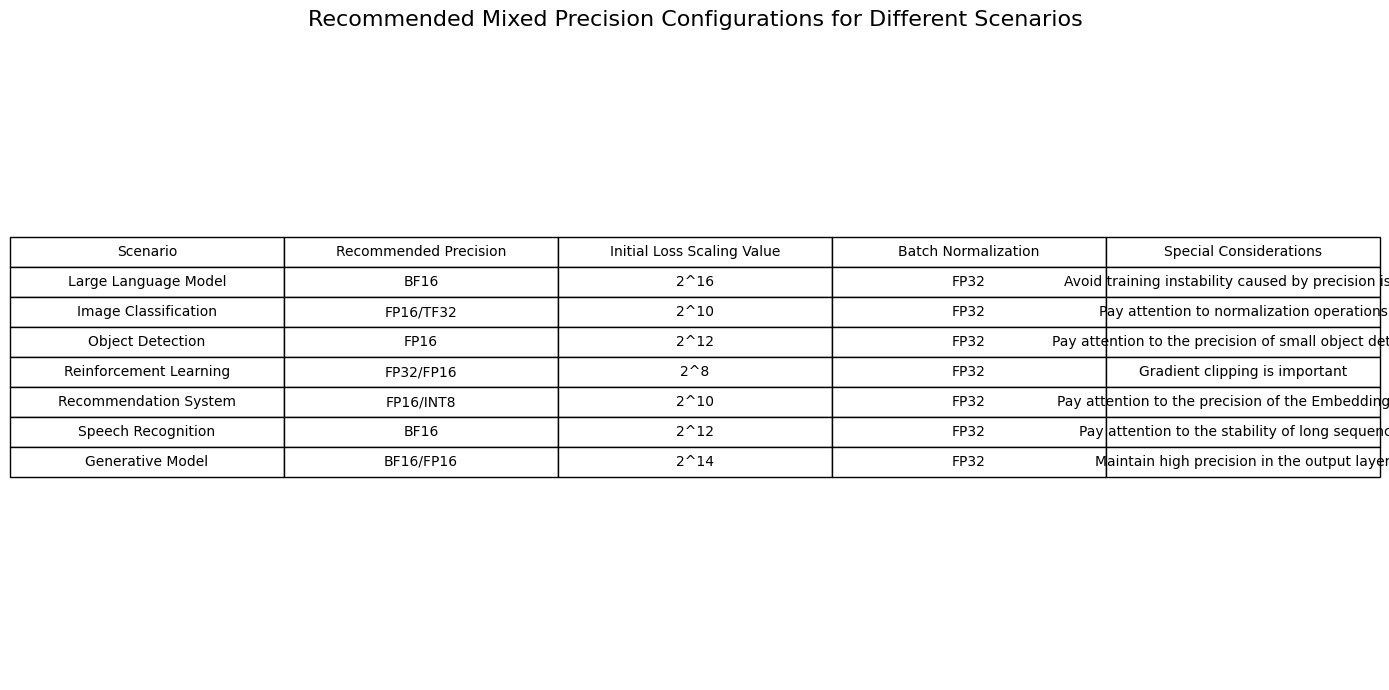

In [ ]:


# mixed_precision_best_practices()
import matplotlib.pyplot as plt


def mixed_precision_best_practices():
    """总结混合精度训练的最佳实践"""

    best_practices = [
        # 1. 优先使用框架提供的AMP API而非手动实现
        "1. Prioritize using the AMP API provided by the framework instead of manual implementation",
        # 2. 始终使用损失缩放防止梯度下溢
        "2. Always use loss scaling to prevent gradient underflow",
        # 3. 将敏感操作保持在FP32精度（如BatchNorm）
        "3. Keep sensitive operations in FP32 precision (e.g., BatchNorm)",
        # 4. 大模型训练优先考虑BF16，小模型可考虑FP16
        "4. Prefer BF16 for large model training and consider FP16 for small models",
        # 5. 生产环境部署前比较不同精度的结果差异
        "5. Compare the differences in results of different precisions before deploying in a production environment",
        # 6. 针对不同硬件平台选择最合适的精度格式
        "6. Select the most suitable precision format for different hardware platforms",
        # 7. 先确保FP32训练稳定，再尝试降低精度
        "7. Ensure stable FP32 training first, then try reducing the precision",
        # 8. 使用梯度裁剪防止训练中的极端值
        "8. Use gradient clipping to prevent extreme values during training",
        # 9. 调整学习率以适应混合精度训练
        "9. Adjust the learning rate to adapt to mixed precision training",
        # 10. 设置动态损失缩放以自动应对不同训练阶段
        "10. Set dynamic loss scaling to automatically handle different training phases"
    ]

    recommended_configs = {
        "Scenario": ["Large Language Model", "Image Classification", "Object Detection", "Reinforcement Learning", "Recommendation System", "Speech Recognition", "Generative Model"],
        "Recommended Precision": ["BF16", "FP16/TF32", "FP16", "FP32/FP16", "FP16/INT8", "BF16", "BF16/FP16"],
        "Initial Loss Scaling Value": ["2^16", "2^10", "2^12", "2^8", "2^10", "2^12", "2^14"],
        "Batch Normalization": ["FP32", "FP32", "FP32", "FP32", "FP32", "FP32", "FP32"],
        "Special Considerations": [
            "Avoid training instability caused by precision issues",
            "Pay attention to normalization operations",
            "Pay attention to the precision of small object detection",
            "Gradient clipping is important",
            "Pay attention to the precision of the Embedding layer",
            "Pay attention to the stability of long sequences",
            "Maintain high precision in the output layer"
        ]
    }

    # 创建最佳实践图表
    plt.figure(figsize=(10, 8))
    plt.axis('off')

    for i, practice in enumerate(best_practices):
        plt.text(0.05, 0.95 - i * 0.09, practice, fontsize=14)

    plt.title('Best Practices for Mixed Precision Training', fontsize=18, pad=20)

    # 添加一些装饰元素
    plt.text(0.5, 0.02, "Improve training speed · Save memory · Maintain precision",
             fontsize=12, ha='center', color='gray')

    # 在图表周围添加边框
    border = plt.Rectangle((0.01, 0.01), 0.98, 0.98, fill=False, color='gray',
                           linestyle='--', transform=plt.gca().transAxes)
    plt.gca().add_patch(border)

    plt.tight_layout()
    plt.show()

    # 创建推荐配置表格
    fig, ax = plt.figure(figsize=(14, 7)), plt.subplot(111)
    ax.axis('off')
    keys_list = list(recommended_configs.keys())  # 将dict_keys对象转换为列表
    table = ax.table(
        cellText=[[recommended_configs[key][i] for key in keys_list]
                  for i in range(len(recommended_configs["Scenario"]))],
        colLabels=keys_list,
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title('Recommended Mixed Precision Configurations for Different Scenarios', fontsize=16)
    plt.tight_layout()
    plt.show()


mixed_precision_best_practices()

6. 学习资源

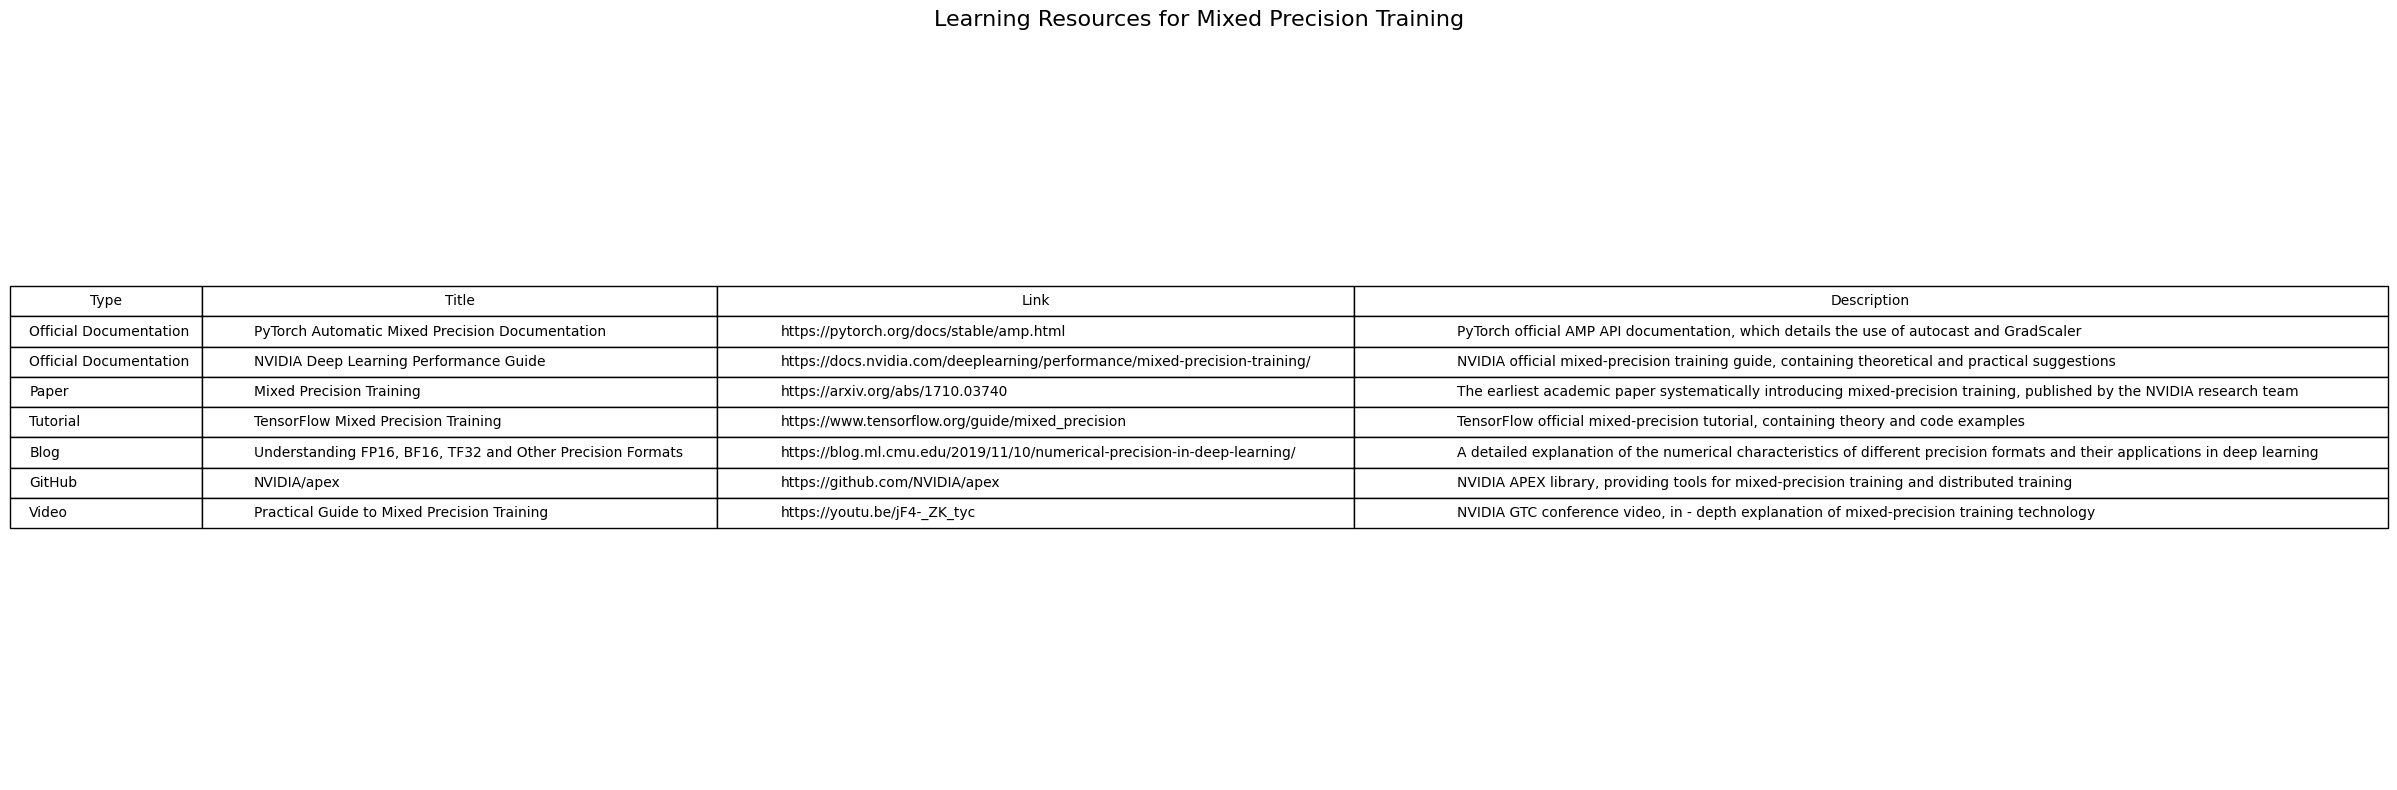

In [ ]:

# show_learning_resources()
import matplotlib.pyplot as plt

def show_learning_resources():
    """显示混合精度训练的学习资源列表"""

    resources = [
        {
            "Type": "Official Documentation",
            "Title": "PyTorch Automatic Mixed Precision Documentation",
            "Link": "https://pytorch.org/docs/stable/amp.html",
            "Description": "PyTorch official AMP API documentation, which details the use of autocast and GradScaler"
        },
        {
            "Type": "Official Documentation",
            "Title": "NVIDIA Deep Learning Performance Guide",
            "Link": "https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/",
            "Description": "NVIDIA official mixed-precision training guide, containing theoretical and practical suggestions"
        },
        {
            "Type": "Paper",
            "Title": "Mixed Precision Training",
            "Link": "https://arxiv.org/abs/1710.03740",
            "Description": "The earliest academic paper systematically introducing mixed-precision training, published by the NVIDIA research team"
        },
        {
            "Type": "Tutorial",
            "Title": "TensorFlow Mixed Precision Training",
            "Link": "https://www.tensorflow.org/guide/mixed_precision",
            "Description": "TensorFlow official mixed-precision tutorial, containing theory and code examples"
        },
        {
            "Type": "Blog",
            "Title": "Understanding FP16, BF16, TF32 and Other Precision Formats",
            "Link": "https://blog.ml.cmu.edu/2019/11/10/numerical-precision-in-deep-learning/",
            "Description": "A detailed explanation of the numerical characteristics of different precision formats and their applications in deep learning"
        },
        {
            "Type": "GitHub",
            "Title": "NVIDIA/apex",
            "Link": "https://github.com/NVIDIA/apex",
            "Description": "NVIDIA APEX library, providing tools for mixed-precision training and distributed training"
        },
        {
            "Type": "Video",
            "Title": "Practical Guide to Mixed Precision Training",
            "Link": "https://youtu.be/jF4-_ZK_tyc",
            "Description": "NVIDIA GTC conference video, in - depth explanation of mixed-precision training technology"
        }
    ]

    # 创建学习资源图表
    fig, ax = plt.figure(figsize=(14, 8)), plt.subplot(111)
    ax.axis('off')

    # 准备表格数据
    table_data = []
    for res in resources:
        table_data.append([res["Type"], res["Title"], res["Link"], res["Description"]])

    table = ax.table(
        cellText=table_data,
        colLabels=["Type", "Title", "Link", "Description"],
        loc='center',
        cellLoc='left'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # 设置列宽
    table.auto_set_column_width([0, 1, 2, 3])

    plt.title('Learning Resources for Mixed Precision Training', fontsize=16)
    plt.tight_layout()
    plt.show()

show_learning_resources()

17. 小结和测验

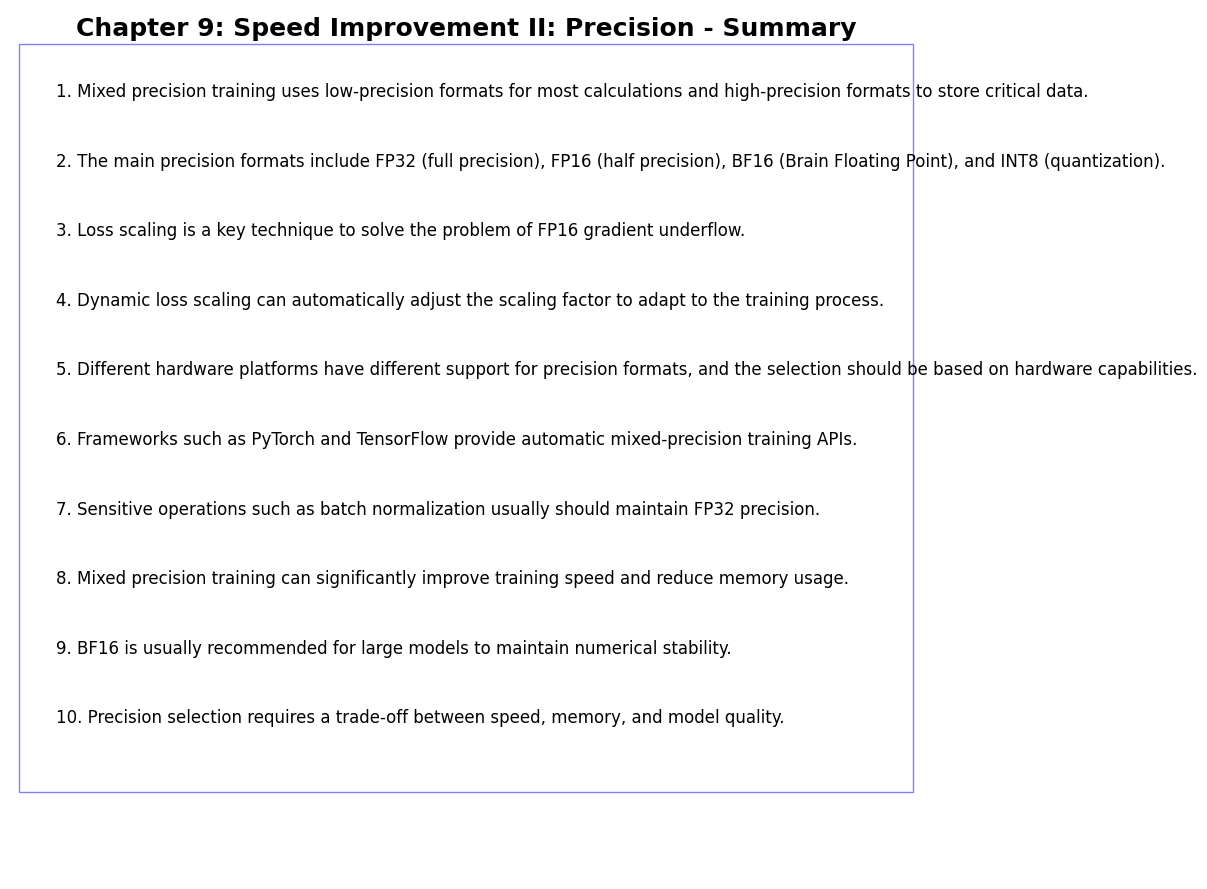

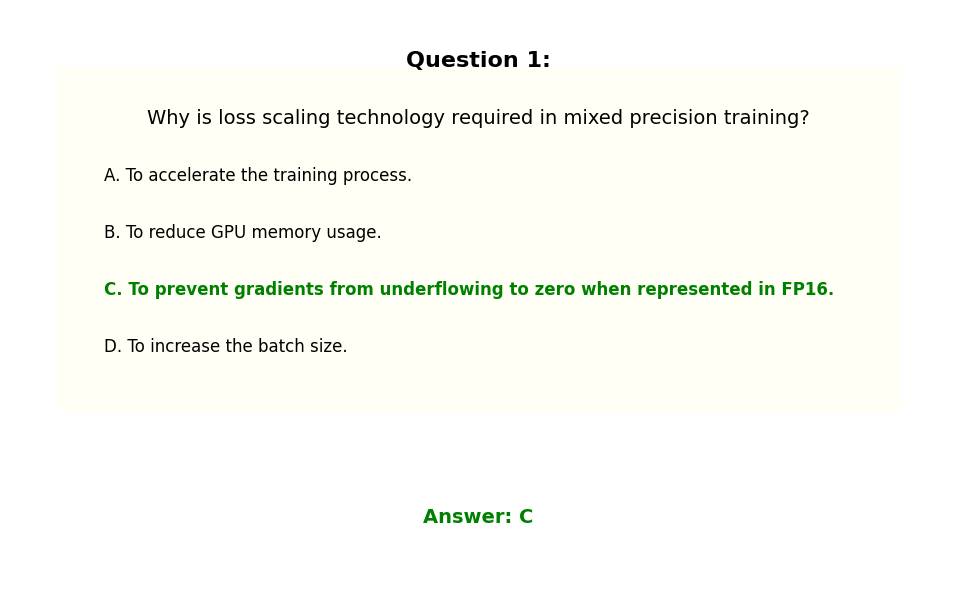

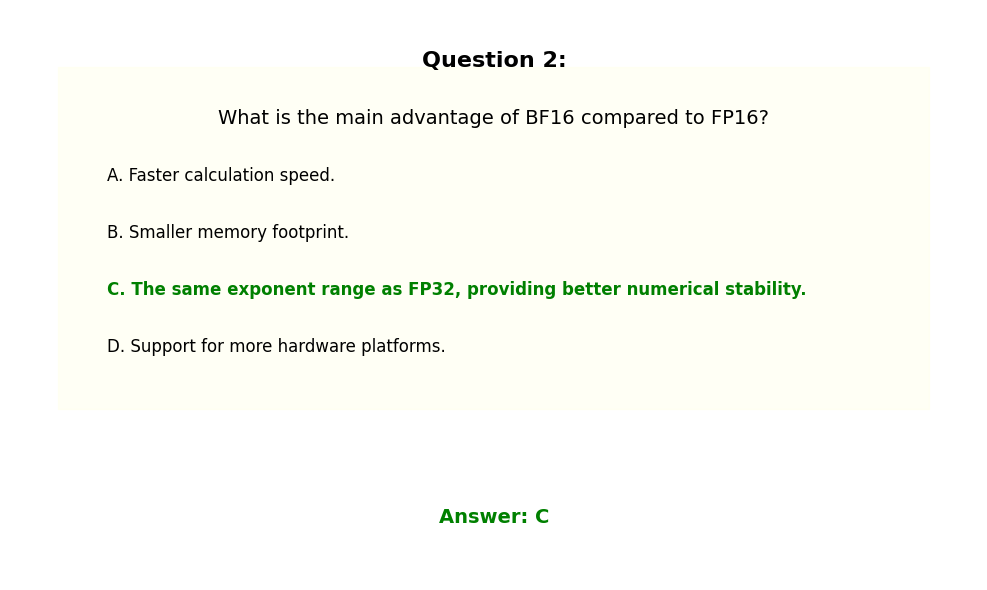

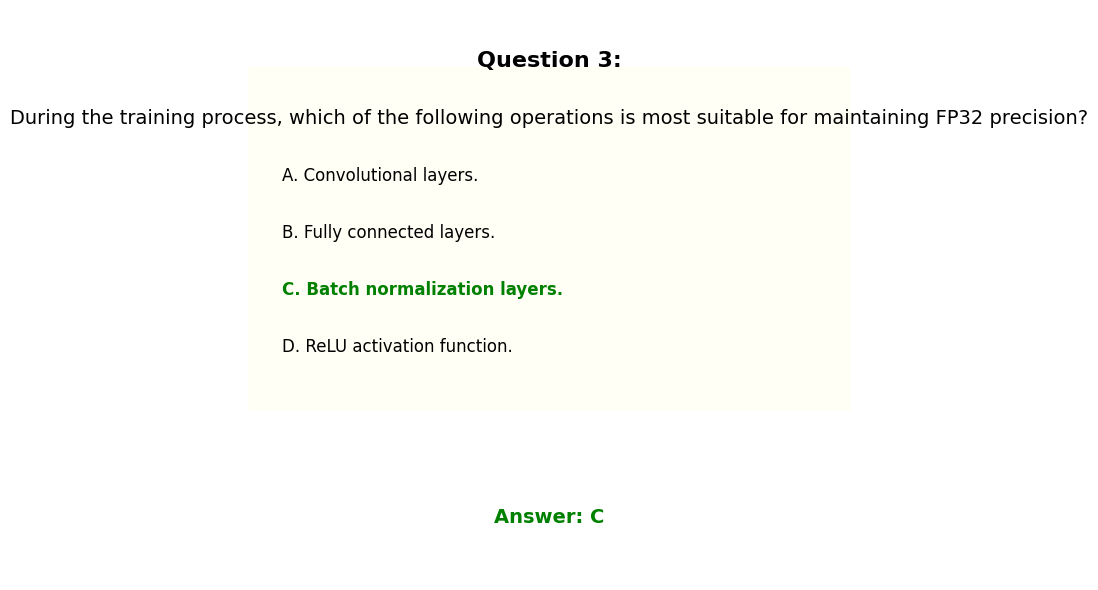

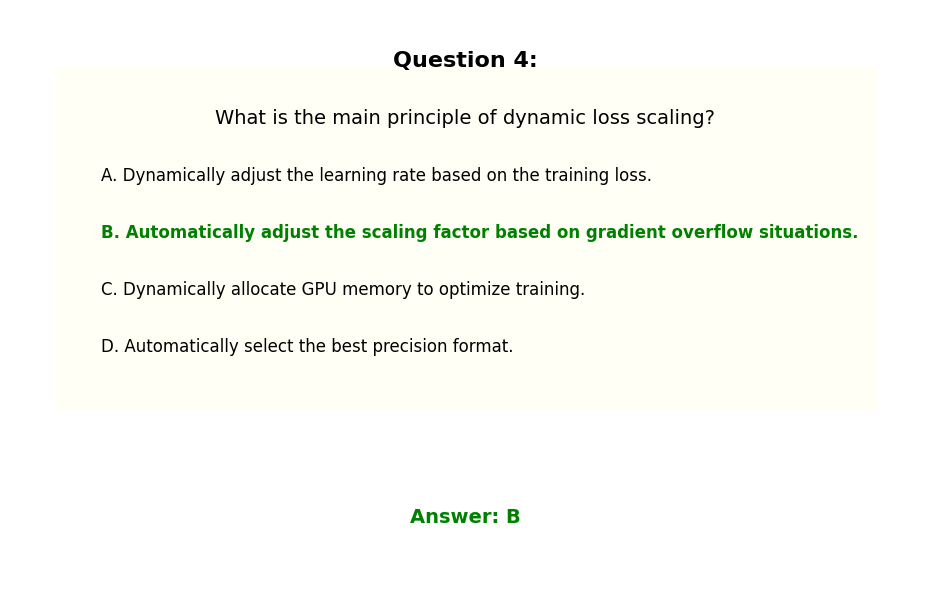

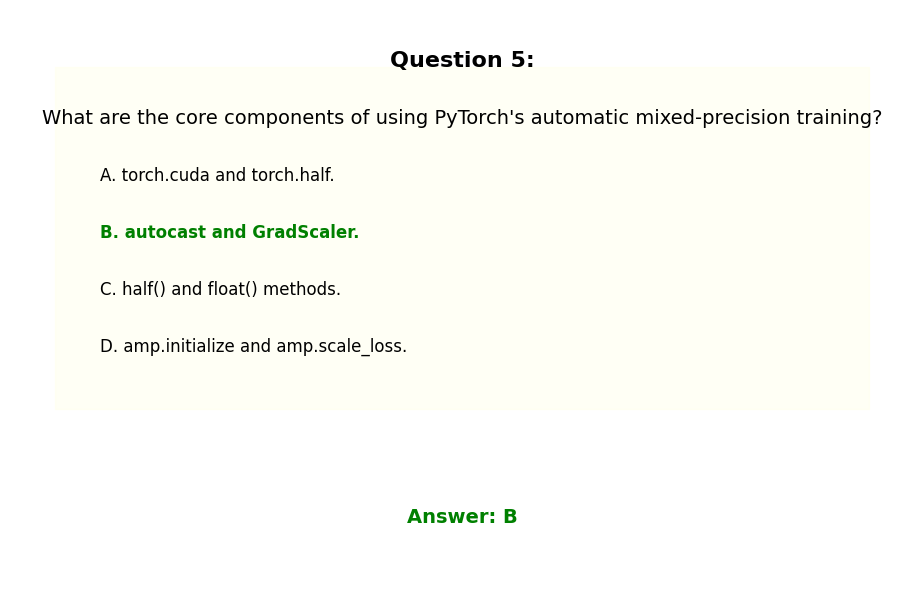

In [35]:
import matplotlib.pyplot as plt


def chapter_summary_quiz():
    """创建章节小结和测验问题"""

    # 章节小结
    summary_points = [
        "1. Mixed precision training uses low-precision formats for most calculations and high-precision formats to store critical data.",
        "2. The main precision formats include FP32 (full precision), FP16 (half precision), BF16 (Brain Floating Point), and INT8 (quantization).",
        "3. Loss scaling is a key technique to solve the problem of FP16 gradient underflow.",
        "4. Dynamic loss scaling can automatically adjust the scaling factor to adapt to the training process.",
        "5. Different hardware platforms have different support for precision formats, and the selection should be based on hardware capabilities.",
        "6. Frameworks such as PyTorch and TensorFlow provide automatic mixed-precision training APIs.",
        "7. Sensitive operations such as batch normalization usually should maintain FP32 precision.",
        "8. Mixed precision training can significantly improve training speed and reduce memory usage.",
        "9. BF16 is usually recommended for large models to maintain numerical stability.",
        "10. Precision selection requires a trade-off between speed, memory, and model quality."
    ]

    # 测验问题
    quiz_questions = [
        {
            "Question": "Why is loss scaling technology required in mixed precision training?",
            "Options": [
                "A. To accelerate the training process.",
                "B. To reduce GPU memory usage.",
                "C. To prevent gradients from underflowing to zero when represented in FP16.",
                "D. To increase the batch size."
            ],
            "Answer": "C"
        },
        {
            "Question": "What is the main advantage of BF16 compared to FP16?",
            "Options": [
                "A. Faster calculation speed.",
                "B. Smaller memory footprint.",
                "C. The same exponent range as FP32, providing better numerical stability.",
                "D. Support for more hardware platforms."
            ],
            "Answer": "C"
        },
        {
            "Question": "During the training process, which of the following operations is most suitable for maintaining FP32 precision?",
            "Options": [
                "A. Convolutional layers.",
                "B. Fully connected layers.",
                "C. Batch normalization layers.",
                "D. ReLU activation function."
            ],
            "Answer": "C"
        },
        {
            "Question": "What is the main principle of dynamic loss scaling?",
            "Options": [
                "A. Dynamically adjust the learning rate based on the training loss.",
                "B. Automatically adjust the scaling factor based on gradient overflow situations.",
                "C. Dynamically allocate GPU memory to optimize training.",
                "D. Automatically select the best precision format."
            ],
            "Answer": "B"
        },
        {
            "Question": "What are the core components of using PyTorch's automatic mixed-precision training?",
            "Options": [
                "A. torch.cuda and torch.half.",
                "B. autocast and GradScaler.",
                "C. half() and float() methods.",
                "D. amp.initialize and amp.scale_loss."
            ],
            "Answer": "B"
        }
    ]

    # 显示章节小结
    plt.figure(figsize=(12, 9))
    plt.axis('off')

    plt.text(0.5, 0.97, "Chapter 9: Speed Improvement II: Precision - Summary", fontsize=18,
             ha='center', weight='bold')

    for i, point in enumerate(summary_points):
        plt.text(0.05, 0.9 - i * 0.08, point, fontsize=12)

    # 在图表周围添加边框
    border = plt.Rectangle((0.01, 0.1), 0.98, 0.86, fill=False, color='blue',
                           linestyle='-', transform=plt.gca().transAxes, alpha=0.5)
    plt.gca().add_patch(border)

    plt.tight_layout()
    plt.show()

    # 显示测验问题
    for i, quiz in enumerate(quiz_questions):
        plt.figure(figsize=(10, 6))
        plt.axis('off')

        plt.text(0.5, 0.9, f"Question {i + 1}:", fontsize=16, ha='center', weight='bold')
        plt.text(0.5, 0.8, quiz["Question"], fontsize=14, ha='center')

        for j, option in enumerate(quiz["Options"]):
            color = 'black'
            weight = 'normal'
            if option.startswith(quiz["Answer"]):
                color = 'green'
                weight = 'bold'
            plt.text(0.1, 0.7 - j * 0.1, option, fontsize=12, color=color, weight=weight)

        # 添加半透明背景
        background = plt.Rectangle((0.05, 0.3), 0.9, 0.6, fill=True, color='lightyellow',
                                   alpha=0.3, transform=plt.gca().transAxes)
        plt.gca().add_patch(background)

        plt.text(0.5, 0.1, f"Answer: {quiz['Answer']}", fontsize=14, ha='center',
                 color='green', weight='bold')

        plt.tight_layout()
        plt.show()


chapter_summary_quiz()

结语

以上Notebook提供了一系列可视化和模拟实验，帮助理解混合精度训练的各个方面。通过这些代码和图表，我们可以更直观地理解不同浮点格式的特点、损失缩放的原理以及混合精度训练的最佳实践。
这些示例代码可以在兼容PyTorch的环境中运行，建议在具有GPU的环境中测试以获得最佳体验。要注意的是，一些功能（如BF16支持）可能需要较新版本的PyTorch和支持相应精度的硬件。